In [2280]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import skew
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


For this project, I selected a dataset containing detailed information about homes sold in Ames, Iowa, from 2006 to 2010. There are 1,460 observations and 81 explanatory variables. The data was obtained from Kaggle and satisfied the dataset conditions outlined in the project instructions. This dataset was chosen due to my interest in investing and my background in developing and back-testing strategies across a wide range of securities. The real estate market is a new area of interest for me, and I would like to leverage the techniques learned in this class to better understand this market.


For my final project, I wanted to create a model that could be utilized to predict a given property value. As an investor, it is crucial to have tools to analyze and detect undervalued real estate properties. A model that can predict a home's value can assist in ROI calculations for undervalued homes, aiding in the decision-making process. Such a model will improve the due diligence process of property assessment and mitigate the risks of tying up capital in homes with low ROI. 


In addition, I wanted to utilize this final project to gather more profound insight into the feature importance of a property. Every market or area is different, and as a property rehabilitation investor, such knowledge is crucial. It will allow for efficient resource allocation to the features that will increase the value of the home the most. For example, if central air conditioning is found to be a significant feature in a home's valuation, it might be wise to consider adding this to an investment property that does not contain it. 

Research question 1: What features are most important to a properties valuation.

Research question 2: How accurately can a properties price be predicted. 

In [2281]:
# Import data

# Providing location
loc = r'C:\Users\cocob\OneDrive\Documents\Boston College\Spring 2024\Python For Data Science\Final Project\house-prices-advanced-regression-techniques\train.csv'

# Creating dataframe
df = pd.read_csv(loc)

In [2282]:
# Conducting exploritory analysis 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [2283]:
# dropping ID column
df = df.drop(['Id'], axis=1)

There are a significant number of features in this dataset, containing both categorical and continuous features. There are a few things of concern. First, the info() method reveals that some variables are missing data. Therefore, I will need to investigate if there is any systematic missingness.

Due to the numerous features, there is likely redundancy in the explained variation of the 'SalePrice' variable by the predictors. In other words, multicollinearity might be present, causing instability in the regression coefficients.
During the modeling stage, I intend to use lasso regression. Thus, as this modeling forces some regression coefficients to zero, it may remove redundant variables.

Investigating multicollinearity in the context of predictive analytics, it does not seem to be as detrimental as it is in explanation modeling. The goal in explanation modeling is parameter estimation, whereas predictive modeling goal is accuracy (Mkt, 2018). For example, an explanation model using multiple regression can be used to examine the relationship between the prestige of a job and whether it is blue collar or not. In this example the regression coefficients are utilized to infer the relationship between the response and outcome variables. If the response variables are perfectly linear, then there are infinitely many ways to show the relationship (Mkt, 2018). This creates a problem for inference as the regression coefficients will be unstable and not capture the true population regression coefficients.

In predictive modeling, the only concern is that the covariance structure in the training dataset is similar to the out-of-sample data (Mkt, 2018). In this case, the out-of-sample dataset would be the testing dataset. As this assumption is met, the multicollinearity concerns in explanation modeling do not apply to the objective of prediction (Morris & Lieberman, 2018).

References

mkt. (2018, August 10). Multicollinearity and predictive performance. Cross Validated. Retrieved from https://stats.stackexchange.com/q/361609

Morris, J. D., & Lieberman, M. G. (2018). Multicollinearity's effect on regression prediction accuracy with real data structures. General Linear Model Journal, 44(1), 29–34.


# Missing data analysis # 

In [2284]:
# Reviewing how which columns contain missing data
pd.set_option('display.max_rows', 500)

# Storing missing values
missing = df.isna().sum().sort_values(ascending = False)

# Display
missing[missing != 0]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

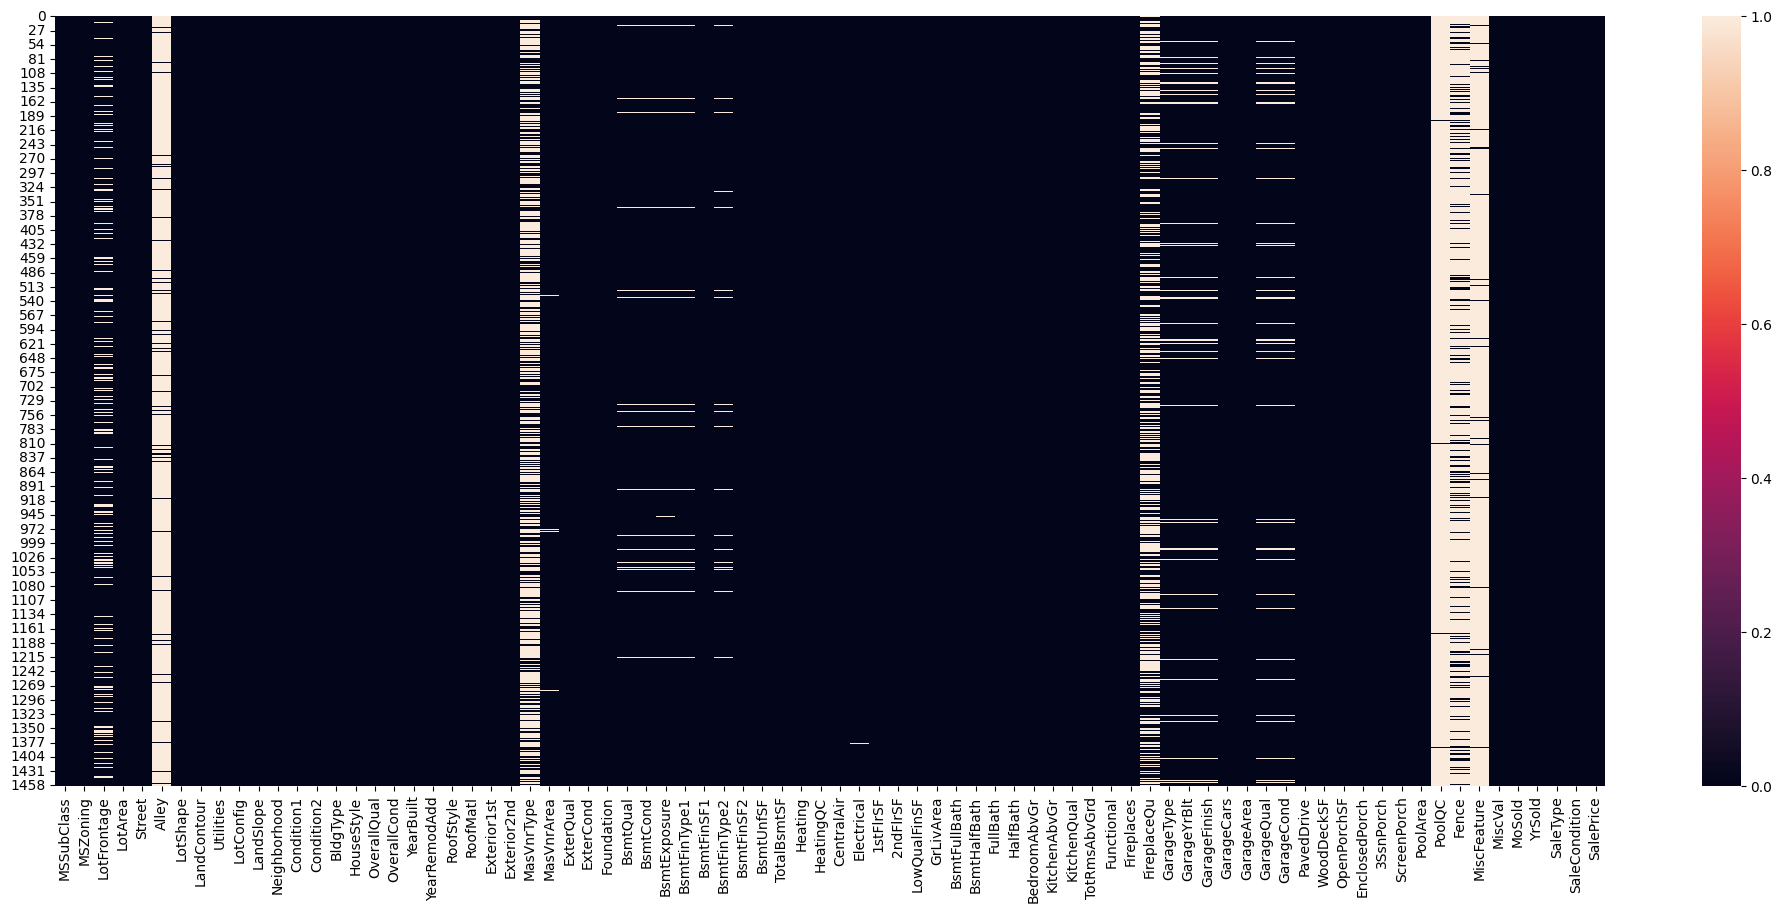

In [2285]:
# Create a missing data plot
plt.figure(figsize=(25,10))
sns.heatmap(df.isna())
plt.show()

There is a significant amount of missing data in this dataset. It appears that much of this missingness to related to how a property denoted if it contained a certain feature or not. For example, the 'Alley' feature has a substantial amount of missingness, but it is likely becuase not many homes in this dataset have an access to the property through an alley.

There are some observations that are truly missing and merit a data imputation strategy. We have case 1379 which contains only one missing value for the feature 'Electrical'. This feature refers to the type of electrical system. We can look at the value counts and impute with the most common electrical system. Doing this does not raise ethical/bias concerns, nor does it have a great impact on the numerical distribution of electrical feature. 

The ‘LotFrontage’ contains a significant amount of missing data. Lot frontage refers to the horizontal distance at the front of the property typically adjacent to a significant landmark or feature, such as a street. I do not think that most properties do not have any lot frontage. From my understanding, zero lot frontage implies that the property is landlocked. I will explore the data through a correlation analysis to reveal if linear interpolation is appropriate. If not, I will remove this variable as there is a significant amount of missing data. The removal of this feature does not raise any concerns for the introduction of bias or ethical concerns. 


### Performing value counts of various features ###

In [2286]:
# Value counts of 'Electrical'
df['Electrical'].value_counts()

Electrical
SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: count, dtype: int64

In [2287]:
# For the missing value observartion 1379, we can imputate with the most common eletrical system

# Creating an object to store the most frequent eletrical system
elec = df['Electrical'].mode()

# Updating observation 1379
df.loc[1379,'Electrical'] = elec[0]

In [2288]:
# Value counts of 'BsmtFinType2'
df['BsmtFinType2'].value_counts()

BsmtFinType2
Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: count, dtype: int64

In [2289]:
# Value counts of 'Alley'
df['Alley'].value_counts()

Alley
Grvl    50
Pave    41
Name: count, dtype: int64

There are no observations that contain 'no alley access'. Thus, this will need to be imputated. A similar observation can be made for many of the variables in this dataset.

In [2290]:
# Value counts of 'MasVnrArea'
df['MasVnrArea'].value_counts()

MasVnrArea
0.0       861
180.0       8
72.0        8
108.0       8
120.0       7
16.0        7
200.0       6
340.0       6
106.0       6
80.0        6
132.0       5
320.0       5
360.0       5
84.0        5
170.0       5
220.0       4
336.0       4
183.0       4
252.0       4
196.0       4
300.0       4
268.0       4
40.0        4
168.0       4
100.0       4
270.0       4
210.0       4
76.0        4
288.0       4
216.0       4
160.0       4
178.0       4
246.0       4
456.0       4
74.0        3
70.0        3
50.0        3
44.0        3
272.0       3
226.0       3
104.0       3
116.0       3
90.0        3
145.0       3
148.0       3
42.0        3
110.0       3
128.0       3
85.0        3
136.0       3
420.0       3
186.0       3
256.0       3
166.0       3
350.0       3
130.0       3
99.0        3
176.0       3
174.0       3
208.0       3
312.0       3
169.0       3
240.0       3
82.0        3
289.0       2
232.0       2
95.0        2
18.0        2
338.0       2
298.0       2
236.0    

In [2291]:
# Value counts for 'FireplaceQu'
df['FireplaceQu'].value_counts()

FireplaceQu
Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: count, dtype: int64

In [2292]:
# Confirming that NaN values correspond to properties without fireplaces
df[['Fireplaces','FireplaceQu']].head()

,Fireplaces,FireplaceQu
0,0,NaN
1,1,TA
2,1,TA
3,1,Gd
4,1,TA


In [2293]:
# Confirming that NaN values correspond to properties without pools
df[['PoolArea','PoolQC']].iloc[1420:1426,:]

,PoolArea,PoolQC
1420,0,NaN
1421,0,NaN
1422,0,NaN
1423,738,Gd
1424,0,NaN
1425,0,NaN


We can see that homes that have no pool are represented as having zero square feet for 'PoolArea' and NaN values for 'PoolQC'.

An additional observation is that this feature is of ordinal categorical nature. It is important to encode this differently than nominal variables. 

In [2294]:
# Value counts for 'Fence'
df['Fence'].value_counts()

Fence
MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: count, dtype: int64

In [2295]:
# Value for 'MiscFeature'
df['MiscFeature'].value_counts()

MiscFeature
Shed    49
Gar2     2
Othr     2
TenC     1
Name: count, dtype: int64

### Missing data imputations ###

In [2296]:
# Creating lists of missing cols with missing data to be reassigned
cat_missing_cols = ['Fence','Alley','MasVnrType','FireplaceQu', 'Fireplaces', 
                    'PoolQC','MiscFeature','GarageType','GarageFinish','GarageQual','GarageCond',
                   'BsmtExposure','BsmtFinType2','BsmtCond','BsmtQual','BsmtFinType1']

# Creating a list of numerical data to be reassigned
num_missing_cols = ['PoolArea','MasVnrArea','GarageYrBlt']

In [2297]:
# Creating a function to reassign missing categorical values
def miss_change_cat(data):
    if pd.isnull(data) == True:
        return 'None'
    else:
        return data

# Creating a function to reassign missing numerical values
def miss_change_num(data):
    if pd.isnull(data) == True:
        return 0
    else:
        return data

# Creating loop to correct missing values for categorical variables
for var in cat_missing_cols:
    df[var] = df[var].apply(miss_change_cat)

# Creating loop to correct missing values for numerical variables    
for var in num_missing_cols:
    df[var] = df[var].apply(miss_change_num)

# Checking results
print(df['MiscFeature'].value_counts())

# Checking results
df['PoolArea'].value_counts()

MiscFeature
None    1406
Shed      49
Gar2       2
Othr       2
TenC       1
Name: count, dtype: int64


PoolArea
0      1453
512       1
648       1
576       1
555       1
480       1
519       1
738       1
Name: count, dtype: int64

In [2298]:
# Dropping missing data in LotFrontage to conduct correlation analysis
df_clean = df.dropna()

In [2299]:
# Preventing truncation of output results
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Lets look at correlation matrix to see if any variables are correlated 

# selecting only numerical types
num_values = df.select_dtypes(include=np.number)

# Creating a list of those columns
num_value_list = list(num_values)


# Creating a empty table to imput values
corr_table = pd.DataFrame(index=num_value_list, columns=num_value_list)
p_table = pd.DataFrame(index=num_value_list, columns=num_value_list)

# Creating a loop to create correlation matrix
for var1 in num_value_list:
    for var2 in num_value_list:
        if var1 == var2:
            corr_table.loc[var1,var2] = 1
            p_table.loc[var1,var2] = 1
        else:
            corr, p_value = pearsonr(df_clean[var1],df_clean[var2])
            corr_table.loc[var1,var2] = corr
            p_table.loc[var1,var2] = p_value

corr_table

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1,-0.386347,-0.201324,0.007245,-0.054996,-0.00332,0.008877,0.02758,-0.068826,-0.058654,-0.152923,-0.244595,-0.253092,0.314716,0.052905,0.079077,0.0062,0.008037,0.13123,0.182693,-0.004283,0.298137,0.056012,-0.05214,-0.095452,-0.078967,-0.126988,-0.021622,-0.002794,-0.016361,-0.039841,-0.026902,0.001243,0.009628,-0.025693,-0.008777,-0.099311
LotFrontage,-0.386347,1,0.426095,0.251646,-0.059213,0.123349,0.088866,0.192411,0.233633,0.0499,0.132644,0.392075,0.457181,0.080177,0.038469,0.402797,0.100949,-0.007234,0.198769,0.053532,0.26317,-0.006069,0.352096,0.266639,0.105237,0.285691,0.344997,0.088521,0.151972,0.0107,0.070029,0.041383,0.206167,0.003368,0.0112,0.00745,0.351799
LotArea,-0.201324,0.426095,1,0.182164,-0.036989,0.049649,0.038877,0.114832,0.233019,0.13815,0.022146,0.311256,0.339195,0.079491,0.01368,0.313833,0.172892,-0.009576,0.141771,0.052194,0.139944,-0.021827,0.243589,0.264678,0.08353,0.187534,0.220754,0.140538,0.09767,-0.028472,0.014753,0.077491,0.109679,0.003461,0.010234,-0.009112,0.311416
OverallQual,0.007245,0.251646,0.182164,1,-0.127473,0.588387,0.561476,0.426702,0.268529,-0.057141,0.311491,0.570354,0.521423,0.281096,-0.02893,0.608072,0.130974,-0.037593,0.564011,0.267413,0.107321,-0.191,0.444741,0.429673,0.296131,0.613333,0.583633,0.285692,0.329318,-0.151628,0.023171,0.068862,0.079776,-0.071876,0.082676,-0.023828,0.802287
OverallCond,-0.054996,-0.059213,-0.036989,-0.127473,1,-0.4016,0.06066,-0.159684,-0.049983,0.043556,-0.146971,-0.183888,-0.166526,0.014451,0.027748,-0.106823,-0.051512,0.118858,-0.217805,-0.073933,-0.007355,-0.087957,-0.093621,-0.023156,-0.027814,-0.212307,-0.185092,-0.010878,-0.057058,0.065066,-0.006558,0.081619,-0.022275,0.079969,-0.011262,0.039027,-0.112568
YearBuilt,-0.00332,0.123349,0.049649,0.588387,-0.4016,1,0.596803,0.339247,0.255829,-0.039131,0.168877,0.42066,0.330424,-0.017862,-0.189655,0.207794,0.188498,-0.034912,0.482933,0.230096,-0.065242,-0.176873,0.110694,0.163838,0.269278,0.542624,0.498433,0.243046,0.200519,-0.401409,0.032092,-0.045609,0.010071,-0.093171,0.018235,-0.015869,0.538913
YearRemodAdd,0.008877,0.088866,0.038877,0.561476,0.06066,0.596803,1,0.19347,0.136213,-0.049508,0.190322,0.314587,0.283277,0.114974,-0.056448,0.295415,0.12013,-0.010155,0.455573,0.168202,-0.05148,-0.15916,0.195553,0.135273,0.14283,0.426129,0.3886,0.237607,0.25047,-0.200266,0.027727,-0.026519,0.020141,-0.059472,0.030273,0.034867,0.519471
MasVnrArea,0.02758,0.192411,0.114832,0.426702,-0.159684,0.339247,0.19347,1,0.2887,-0.069151,0.110975,0.386427,0.366801,0.180288,-0.071244,0.408493,0.1058,0.00456,0.286048,0.197854,0.10847,-0.041596,0.306673,0.266094,0.134668,0.37067,0.380584,0.182111,0.118812,-0.120686,0.025779,0.061081,0.023809,-0.051731,0.016056,-0.022142,0.492084
BsmtFinSF1,-0.068826,0.233633,0.233019,0.268529,-0.049983,0.255829,0.136213,0.2887,1,-0.032732,-0.493501,0.531107,0.466391,-0.1165,-0.065926,0.237895,0.655299,0.068115,0.067291,0.021622,-0.096804,-0.076764,0.07587,0.274777,0.114611,0.219939,0.294792,0.215005,0.123278,-0.109404,0.023907,0.064489,0.190981,-0.010105,-0.011819,0.002841,0.403195
BsmtFinSF2,-0.058654,0.0499,0.13815,-0.057141,0.043556,-0.039131,-0.049508,-0.069151,-0.032732,1,-0.213595,0.096913,0.075265,-0.103149,0.023623,-0.02755,0.165684,0.055477,-0.070291,-0.030109,-0.001877,-0.048455,-0.047642,0.031159,0.030755,-0.040836,-0.021116,0.037899,0.00532,0.037634,-0.029297,0.069646,0.061139,0.007792,-0.032273,0.034684,-0.017682


In [2300]:
# Obtaining features that are correlated with 'LotFrontage'
corr_table['LotFrontage'].sort_values(ascending=False)

LotFrontage             1
1stFlrSF         0.457181
LotArea          0.426095
GrLivArea        0.402797
TotalBsmtSF      0.392075
TotRmsAbvGrd     0.352096
SalePrice        0.351799
GarageArea       0.344997
GarageCars       0.285691
Fireplaces       0.266639
BedroomAbvGr      0.26317
OverallQual      0.251646
BsmtFinSF1       0.233633
PoolArea         0.206167
FullBath         0.198769
MasVnrArea       0.192411
OpenPorchSF      0.151972
BsmtUnfSF        0.132644
YearBuilt        0.123349
GarageYrBlt      0.105237
BsmtFullBath     0.100949
YearRemodAdd     0.088866
WoodDeckSF       0.088521
2ndFlrSF         0.080177
3SsnPorch        0.070029
HalfBath         0.053532
BsmtFinSF2         0.0499
ScreenPorch      0.041383
LowQualFinSF     0.038469
MoSold             0.0112
EnclosedPorch      0.0107
YrSold            0.00745
MiscVal          0.003368
KitchenAbvGr    -0.006069
BsmtHalfBath    -0.007234
OverallCond     -0.059213
MSSubClass      -0.386347
Name: LotFrontage, dtype: object

In [2301]:
# Amount of missingness for the 'LotFrontage' feature
df['LotFrontage'].isna().sum()

259

### Creating plots to illustrate the relationships of the strongest correlations ### 

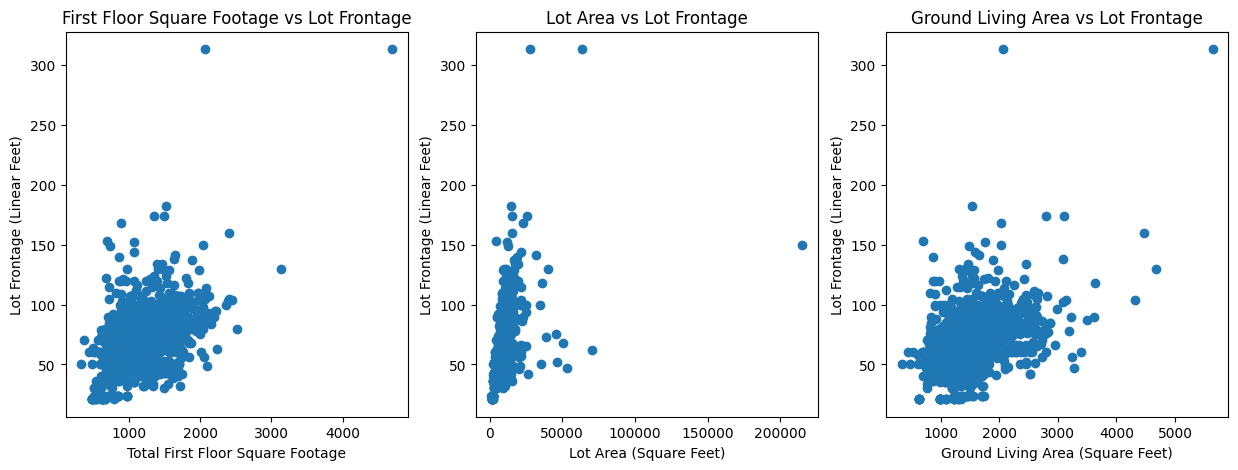

In [2302]:
# Creating subplots
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

# Flattening axes
axes = axes.flatten()

# plotting
axes[0].scatter(df['1stFlrSF'], df['LotFrontage'])
axes[1].scatter(df['LotArea'], df['LotFrontage'])
axes[2].scatter(df['GrLivArea'], df['LotFrontage'])


# Adding Title Labels
axes[0].set_title('First Floor Square Footage vs Lot Frontage')
axes[1].set_title('Lot Area vs Lot Frontage')
axes[2].set_title('Ground Living Area vs Lot Frontage')


# Adding axis labels
axes[0].set_xlabel('Total First Floor Square Footage')
axes[0].set_ylabel('Lot Frontage (Linear Feet)')
axes[1].set_xlabel('Lot Area (Square Feet)')
axes[1].set_ylabel('Lot Frontage (Linear Feet)')
axes[2].set_xlabel('Ground Living Area (Square Feet)')
axes[2].set_ylabel('Lot Frontage (Linear Feet)')

# Display
plt.show()

Given the moderate correlation amoungst the variables it is best not to use linear interpolation. Likely, the reationship between LotFrontage and the other predictors is truely not linear. Using linear interpolation will then force a linear relationship between LotFrontage and the predictors. This will introduce bias into the the 'LotFrontage' feature. To avoid this potential bias I will remove this feature from the analysis. 

In [2303]:
# Dropping 'LotFrontage'
df = df.drop('LotFrontage',axis=1)

In [2304]:
# Reviewing missness after missing data cleanup
df.isna().sum()

MSSubClass       0
MSZoning         0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd

# Data Exploration #

Let us explore the different features of the dataset to understand what influences price

In [2305]:
# Drop 'SaleType' and 'SaleCondition' as I would like to predict a properties value unconditional on its sale type
df = df.drop(['SaleType','SaleCondition', ], axis=1)

In [2306]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotArea        1460 non-null   int64  
 3   Street         1460 non-null   object 
 4   Alley          1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

There are some features such as 'YearBuilt' and 'YearRemodAdd' who's data types can be improved by converting them into datetime objects. Datetime objects much more powerful that simple numerical or string representation.Datetime objects are better equiped at manipulating temporal data for feature engineering and feature extraction.

In [2307]:
# Converting Temporal features into datatime objects

# Creating a list of temporal features
temporal_features = ['YearBuilt', 'YearRemodAdd','MoSold', 'YrSold']

# Convert temporal features into string representations for better datatime manipulation
df[temporal_features] = df[temporal_features].astype(str)

# Creating a dummy variables to fulfill assemble mappings requirment for the 'to_datetime' method
df_dummy = df.copy()
df_dummy['Day_dummy'] = '1'

# Converting to datetime objects - Creating new Datetime object for data exploration. Retaining original variables will 
# assist during the modeling stage
df['YearBuilt_dt'] = pd.to_datetime(df['YearBuilt'], format='%Y')
df['YearRemodAdd_dt'] = pd.to_datetime(df['YearRemodAdd'], format='%Y')
df['YrMoSold_dt'] = pd.to_datetime(dict(year=df['YrSold'], month=df['MoSold'], day=df_dummy['Day_dummy']))


# https://pandas.pydata.org/docs/user_guide/timeseries.html#providing-a-format-argument
# https://stackoverflow.com/questions/19350806/how-to-convert-columns-into-one-datetime-column-in-pandas

In [2308]:
# Checking transformation
temporal_features = ['YearBuilt_dt', 'YearRemodAdd_dt','YrMoSold_dt']

for var in temporal_features:
    print(" ")
    print(f"Checking Transformation for {var}")
    print(df[var].head())

 
Checking Transformation for YearBuilt_dt
0   2003-01-01
1   1976-01-01
2   2001-01-01
3   1915-01-01
4   2000-01-01
Name: YearBuilt_dt, dtype: datetime64[ns]
 
Checking Transformation for YearRemodAdd_dt
0   2003-01-01
1   1976-01-01
2   2002-01-01
3   1970-01-01
4   2000-01-01
Name: YearRemodAdd_dt, dtype: datetime64[ns]
 
Checking Transformation for YrMoSold_dt
0   2008-02-01
1   2007-05-01
2   2008-09-01
3   2006-02-01
4   2008-12-01
Name: YrMoSold_dt, dtype: datetime64[ns]


In [2309]:
# Let's review what features are correlated with the sales price
corr_sale_price = corr_table['SalePrice'].sort_values(ascending=False)
p_value_sale_price = p_table['SalePrice'].sort_values(ascending=False)

# Mergeing correlation stats with p-value stats
concat_table = pd.merge(corr_sale_price,p_value_sale_price, right_index=True,left_index=True, suffixes=('_corr','_p_value'))

# Display value
print(concat_table)

              SalePrice_corr SalePrice_p_value
SalePrice                  1                 1
OverallQual         0.802287               0.0
GrLivArea           0.703557               0.0
GarageCars          0.647302               0.0
GarageArea          0.631761               0.0
TotalBsmtSF         0.626977               0.0
1stFlrSF            0.620159               0.0
FullBath              0.5668               0.0
YearBuilt           0.538913               0.0
TotRmsAbvGrd        0.537215               0.0
YearRemodAdd        0.519471               0.0
MasVnrArea          0.492084               0.0
Fireplaces          0.479353               0.0
BsmtFinSF1          0.403195               0.0
LotFrontage         0.351799               0.0
WoodDeckSF          0.345054               0.0
OpenPorchSF          0.32653               0.0
LotArea             0.311416               0.0
2ndFlrSF            0.308957               0.0
HalfBath             0.28477               0.0
GarageYrBlt  

We can see that the overall quality of the home is highly positively correlated with price ($r$ = 0.80), which intuitvely make sense. The above grade living area square feet is also highly correlated with a home ($r$=0.70). This is logical as larger homes with more livable square footage should be a big driver in a homes value. 

The correlation analysis reveals interesting details about the features that are moderately correlated. We see that garage square footage has meaningful correlation with price ($r$=0.63). It would be nice to investigate how the valuation of properties differ in terms of having a garage. The number of fireplaces is moderately correlated with the sales price ($r$=0.48). 

The magnitude of those features that are negatively correlated with sales price is not nearly as high as most positively correlated features. Enclosed porches have the strongest inverse relationship with sales price ($r$= -0.16). Interestingly, the number of kitchens above ground level has a slight negative correlation with the sales price. This suggests that most people find having one kitchen sufficient in a home. Any more than this seems like an intrusive use of space.

Something to note that is that the year sold has a slight negative correlation with sale price. This could be attributed to the data collected ranges from 2006 - 2010 when the 2008 housing market crashed. Interestingly, this correlation is not statistically significant at the $\alpha <0.05$ level. 

In [2310]:
# Let's check the descriptive statistics
df.describe()

,MSSubClass,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,YearBuilt_dt,YearRemodAdd_dt,YrMoSold_dt
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460,1460
mean,56.897260,10516.828082,6.099315,5.575342,103.117123,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1868.739726,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,180921.195890,1971-04-08 22:46:01.643835616,1984-11-12 14:16:06.575342464,2008-04-04 02:31:53.424657408
min,20.000000,1300.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34900.000000,1872-01-01 00:00:00,1950-01-01 00:00:00,2006-01-01 00:00:00
25%,20.000000,7553.500000,5.000000,5.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1958.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,129975.000000,1954-01-01 00:00:00,1967-01-01 00:00:00,2007-04-01 00:00:00
50%,50.000000,9478.500000,6.000000,5.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1977.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,163000.000000,1973-01-01 00:00:00,1994-01-01 00:00:00,2008-05-01 00:00:00
75%,70.000000,11601.500000,7.000000,6.000000,164.250000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2001.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,214000.000000,2000-01-01 00:00:00,2004-01-01 00:00:00,2009-06-01 00:00:00
max,190.000000,215245.000000,10.000000,9.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,755000.000000,2010-01-01 00:00:00,2010-01-01 00:00:00,2010-07-01 00:00:00
std,42.300571,9981.264932,1.382997,1.112799,180.731373,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,453.697295,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,79442.502883,NaN,NaN,NaN


Some variables seem to exhibit significant skew, such as lot size and sales price given the large differences between the mean and median. We can analyze this with skewness descriptive statistics to transform any necessary variables.

Reviewing the sales price feature we can see that in Ames, Iowa the median sales price is 163,000 for a property. There is quite a bit of variation in the valuation of a property given by the standard deviation of 79,442.50. The min max price show that there is significant range in this feature. Additionally, the Min Max reveal no extranous values, such as a -1, to convey missingness.

We can see that most homes were sold during the year 2008 around April to May. This could be due to the financial crisis that started in February 2007 when subprime lending markets began to fail. We could create a feature to capture this significant event in our model. A binary dummy variable that can denote which homes were sold during a recession would be sufficient. The issue in doing this is that recessions are often classified retrospectively.

The National Bureau of Economic Research (NBER) classifies a recession as the period between a peak and a trough of economic activity (National Bureau of Economic Research, 2025). A recession is defined as a downturn that is deep, pervasive, and lasting. There is no fixed rule for what measures contribute to the process of determining a recession. Common measures that are used to assess a peak and a trough of economic activity by the NBER are non-farm payroll, industrial production, retail sales, and quarterly GDP.

The NBER committee waits until sufficient information is released before determining peaks and troughs. As a result, the committee tends to wait a number of months after a peak has presented itself to be confident that a recession has occurred. Likewise, in determining periods of expansion, it waits a number of months after a trough has presented itself. This is done mainly to avoid major revisions to the business cycle. Therefore, as it is difficult to determine exact dates of when a recession starts and when it ends without a retrospective lens, I will not attempt to do so in this project. As we are including the dates in which the properties are sold, this may be sufficient in itself to capture the differences in price due to the economic downturn.

References
Investopedia Team. (2025, April 4). Recession: Definition, causes, examples and FAQs. Investopedia. Retrieved April 13, 2025, from https://www.investopedia.com/terms/r/recession.asp

National Bureau of Economic Research. (2025). Business Cycle Dating. Retrieved April 13, 2025, from https://www.nber.org/research/business-cycle-dating

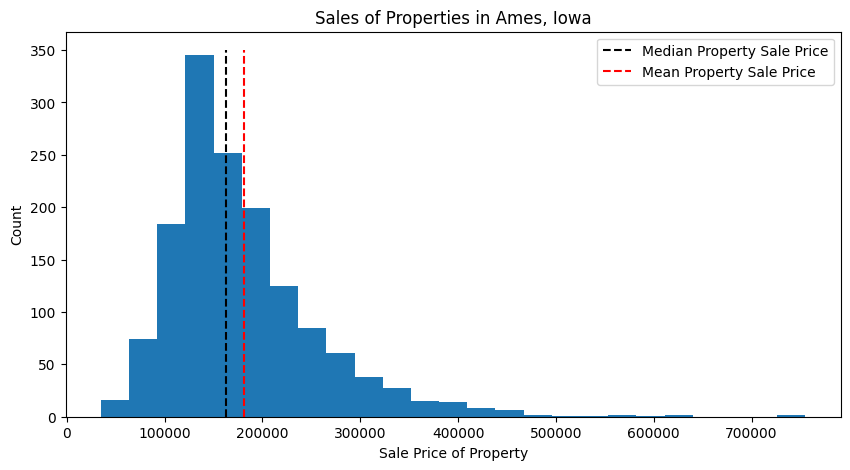

In [2311]:
# Review the average sales price of the dataframe

# Creating figure
plt.figure(figsize=(10,5))

# Creating histogram of the averge sales price 
plt.hist(df['SalePrice'], bins=25)

# Creatiing labels
plt.xlabel('Sale Price of Property')
plt.ylabel('Count')
plt.title('Sales of Properties in Ames, Iowa')

# creating vertical lines of where the mean and median lie 
plt.vlines(x=df['SalePrice'].median(),ymin=0,ymax=350,color='black',linestyles='dashed', label='Median Property Sale Price')
plt.vlines(x=df['SalePrice'].mean(),ymin=0,ymax=350,color='red',linestyles='dashed', label='Mean Property Sale Price')

# Displaying histogram
plt.legend()
plt.show()

There is significant skew with this variable. This will need to be corrected prior to modeling to improve fit.

In [2312]:
# Calculating the median property value
med = df['SalePrice'].median()
avg = df['SalePrice'].mean()

# Display
print('The median property sale price is $',med)
print(f'The mean property sale price is $ {avg:.2f}')

The median property sale price is $ 163000.0
The mean property sale price is $ 180921.20


In [2313]:
# Checking how many different neighborhoods there are
len(df['Neighborhood'].unique())

25

### Neighborhood Analysis ###

In [2314]:
# Identifying the different neighborhoods
df['Neighborhood'].unique()

array(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
       'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
       'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
       'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU',
       'Blueste'], dtype=object)

In [2315]:
# Perfrom groupby analysis to see what the median sales prices of the different neighborhoods
df.groupby('Neighborhood')['SalePrice'].median().sort_values()

Neighborhood
MeadowV     88000.0
IDOTRR     103000.0
BrDale     106000.0
OldTown    119000.0
Edwards    121750.0
BrkSide    124300.0
Sawyer     135000.0
Blueste    137500.0
SWISU      139500.0
NAmes      140000.0
NPkVill    146000.0
Mitchel    153500.0
SawyerW    179900.0
Gilbert    181000.0
NWAmes     182900.0
Blmngtn    191000.0
CollgCr    197200.0
ClearCr    200250.0
Crawfor    200624.0
Veenker    218000.0
Somerst    225500.0
Timber     228475.0
StoneBr    278000.0
NoRidge    301500.0
NridgHt    315000.0
Name: SalePrice, dtype: float64

In [2316]:
# Perfrom groupby analysis to see the number of obsevations in different neighborhoods
df.groupby('Neighborhood')['SalePrice'].count().sort_values()

Neighborhood
Blueste      2
NPkVill      9
Veenker     11
BrDale      16
MeadowV     17
Blmngtn     17
StoneBr     25
SWISU       25
ClearCr     28
IDOTRR      37
Timber      38
NoRidge     41
Mitchel     49
Crawfor     51
BrkSide     58
SawyerW     59
NWAmes      73
Sawyer      74
NridgHt     77
Gilbert     79
Somerst     86
Edwards    100
OldTown    113
CollgCr    150
NAmes      225
Name: SalePrice, dtype: int64

The groupby analysis reveals that there are significant differences in sales prices by neighborhoods. The top five neighborhoods' median sales prices range from 225,000 to 315,000. This is substantially more than the aggregate median price of 163,000. The bottom five neighborhoods have median sales that range from 88,000 to 121,750.

This analysis reveals that there are meaningful differences in median sales prices based on a property's location. Furthermore, this analysis reveals that there is aggregation bias when viewing the median sale prices in aggregate. When looking for potential undervalued homes, this analysis illustrates that it is important to look at the median values relative to the location of the property.

To gather more insight on this analysis, we could create boxplots for each neighborhood. This will reveal additional dimensions of information such as the variation of the sale prices and any outliers.

The counts of observations by neighborhoods show that there are some neighborhoods that lack representation. This lack of representation can affect the predictive performance of the model for those properties in that area. To understand the ethical impact of this, one must evaluate the costs of inaccurate predictions. The costs of inaccurate predictions in the context of property valuation are very low, primarily because they relate to non-human entities and pose no immediate danger. If this was a predictive analytical model for detecting whether a patient has cancer, a lack of representation from particular ethnic groups would be of concern. The resulting inaccuracies from the model of certain ethnic groups can cause cancer detections to be missed and a potential loss of life if not caught otherwise.


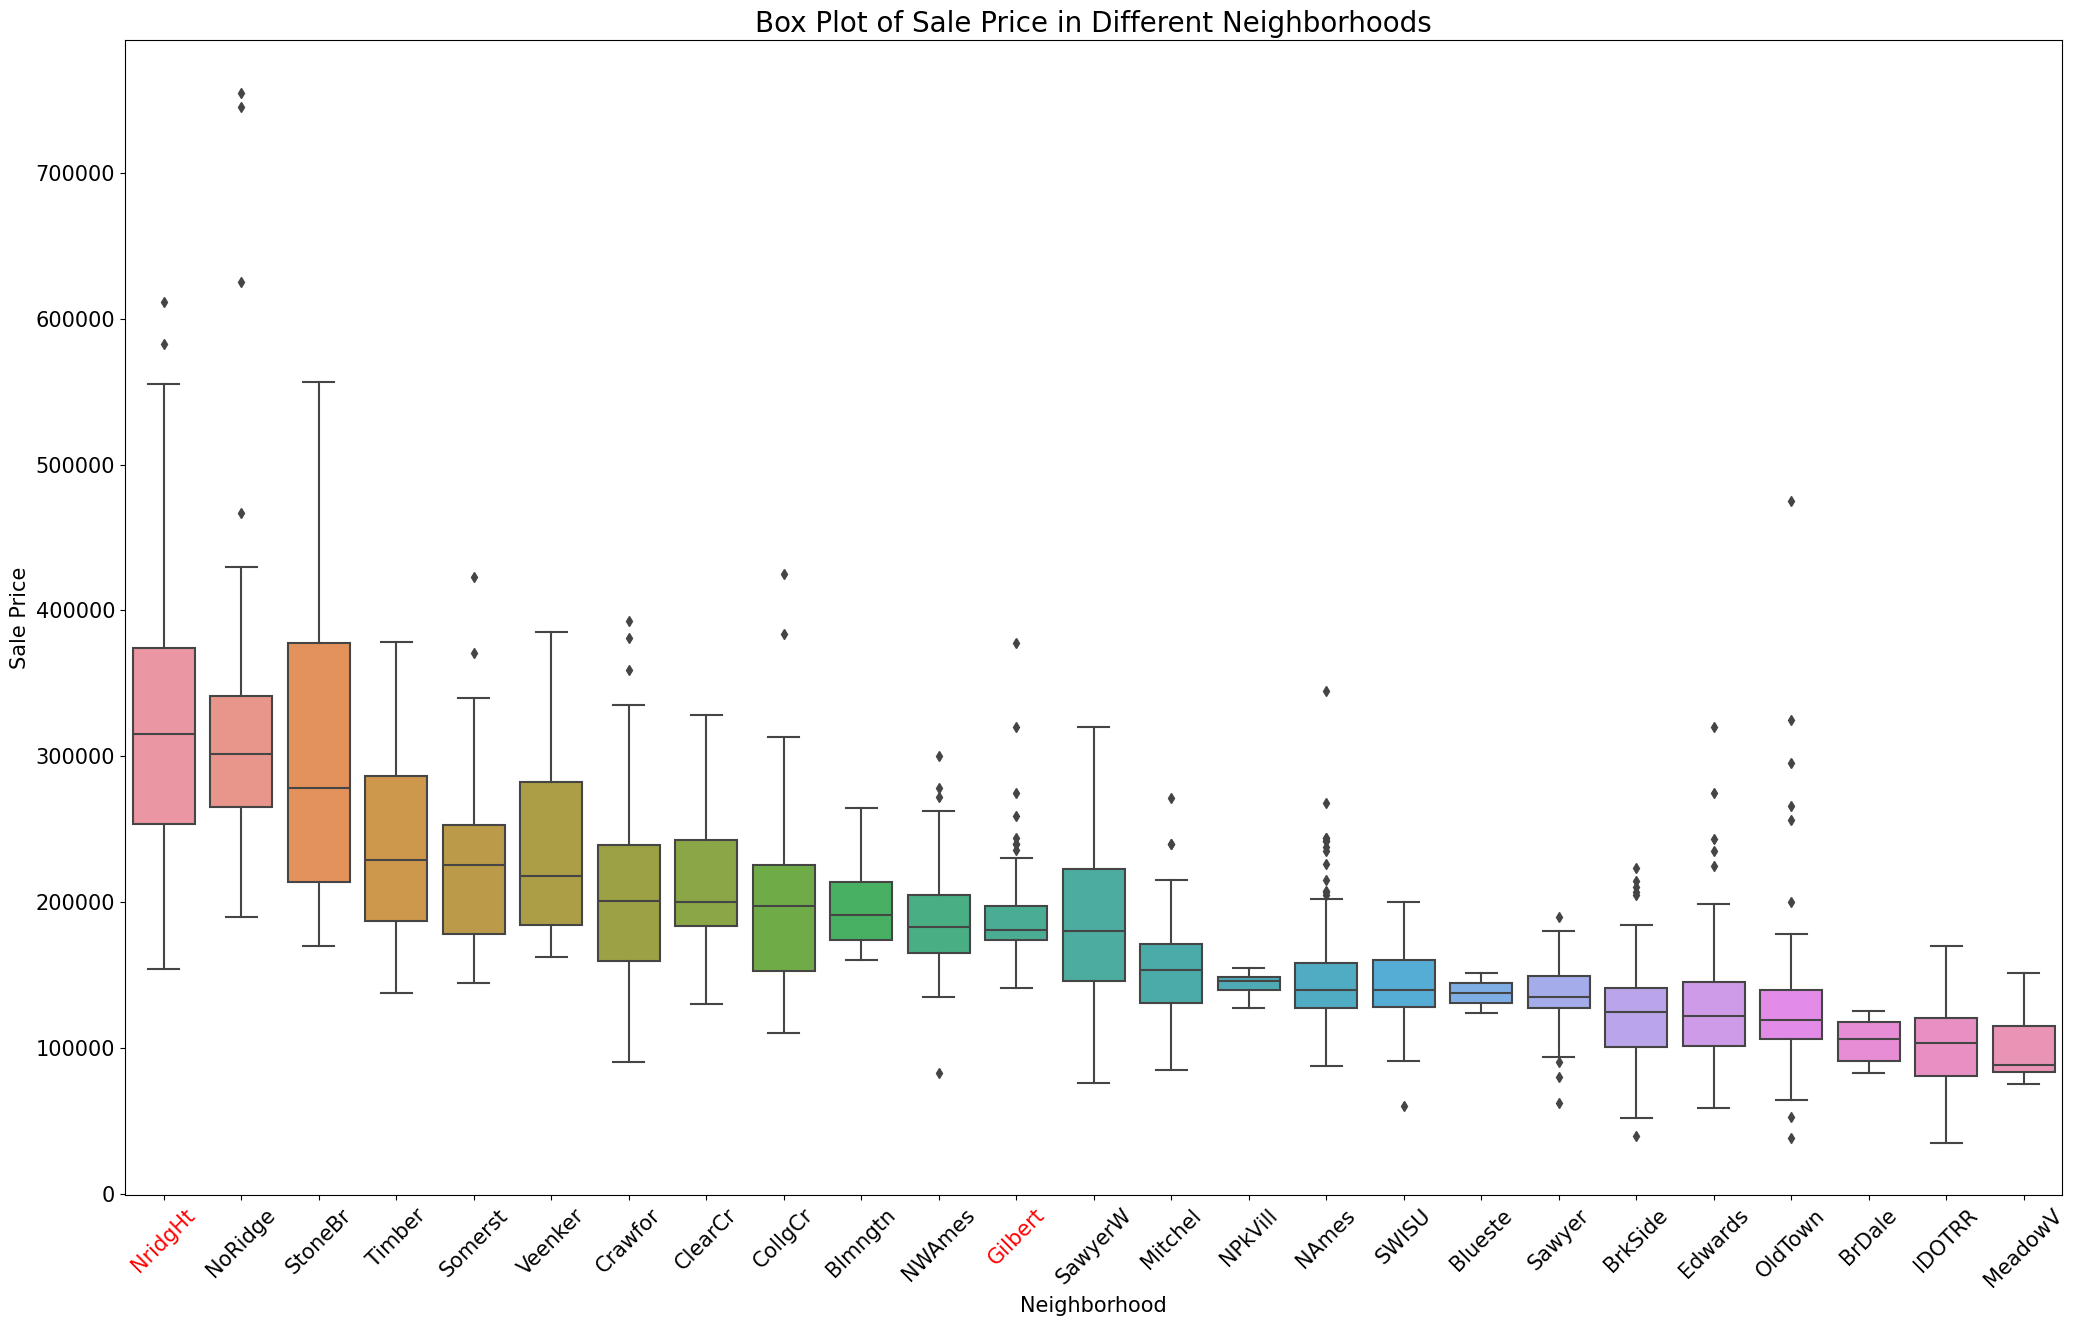

In [2317]:
# Creating a boxplot of the sales prices of the different neighborhoods

# Calculating median sales price by neighborhood
med_neigh = df.groupby('Neighborhood')['SalePrice'].median().sort_values(ascending=False)

# Creating figure
plt.figure(figsize=(25,15))
sns.boxplot(data=df, x='Neighborhood', y='SalePrice', order=med_neigh.index)

# Adjusting labels
plt.xticks(rotation=45, size=15)
plt.yticks(size=15)
plt.xlabel('Neighborhood',fontsize=15)
plt.ylabel('Sale Price',fontsize=15)
plt.title('Box Plot of Sale Price in Different Neighborhoods', fontsize=20)

# Setting 'Nridght' red
plt.gca().get_xticklabels()[0].set_color('r') # https://stackoverflow.com/questions/42878462/changing-the-color-of-a-single-x-axis-tick-label
plt.gca().get_xticklabels()[11].set_color('r')

# Display
plt.show()

The boxplot reveals that there is significant variation in the neighborhood sale prices given by the IQR of the box plots. For example, the 'Nridght' neighborhood whiskers span from 150,000 to what appears to be 550,000. The center 50% of the data is contained between 250,000 to 375,000. Other neighborhoods such as 'Gilbert' have very narrow variation in price. 



## Temporal Changes in Price ##

Due to the significant amount of neighborhoods in our dataset. Let us first compare the change is sale prices for properties with the top five median sale prices and the bottom five median sale prices

In [2318]:
# Filtering for top five properties and bottom five 
med_price_grouped = df.groupby('Neighborhood')['SalePrice'].median().sort_values()

# Resetting index
med_price_grouped = med_price_grouped.reset_index()

# Selecting top five and botton five
top_five = list(med_price_grouped.iloc[20:24,0])
bottom_five = list(med_price_grouped.iloc[0:4,0])

# Display results
print('The top five neighborhoods are:', top_five)
print('The bottom five neighborhoods are:', bottom_five)

# Creating masks
mask_top = df['Neighborhood'].isin(top_five)
mask_bottom = df['Neighborhood'].isin(bottom_five)

# Filering
top_five_df = df[mask_top]
bottom_five_df = df[mask_bottom]

The top five neighborhoods are: ['Somerst', 'Timber', 'StoneBr', 'NoRidge']
The bottom five neighborhoods are: ['MeadowV', 'IDOTRR', 'BrDale', 'OldTown']


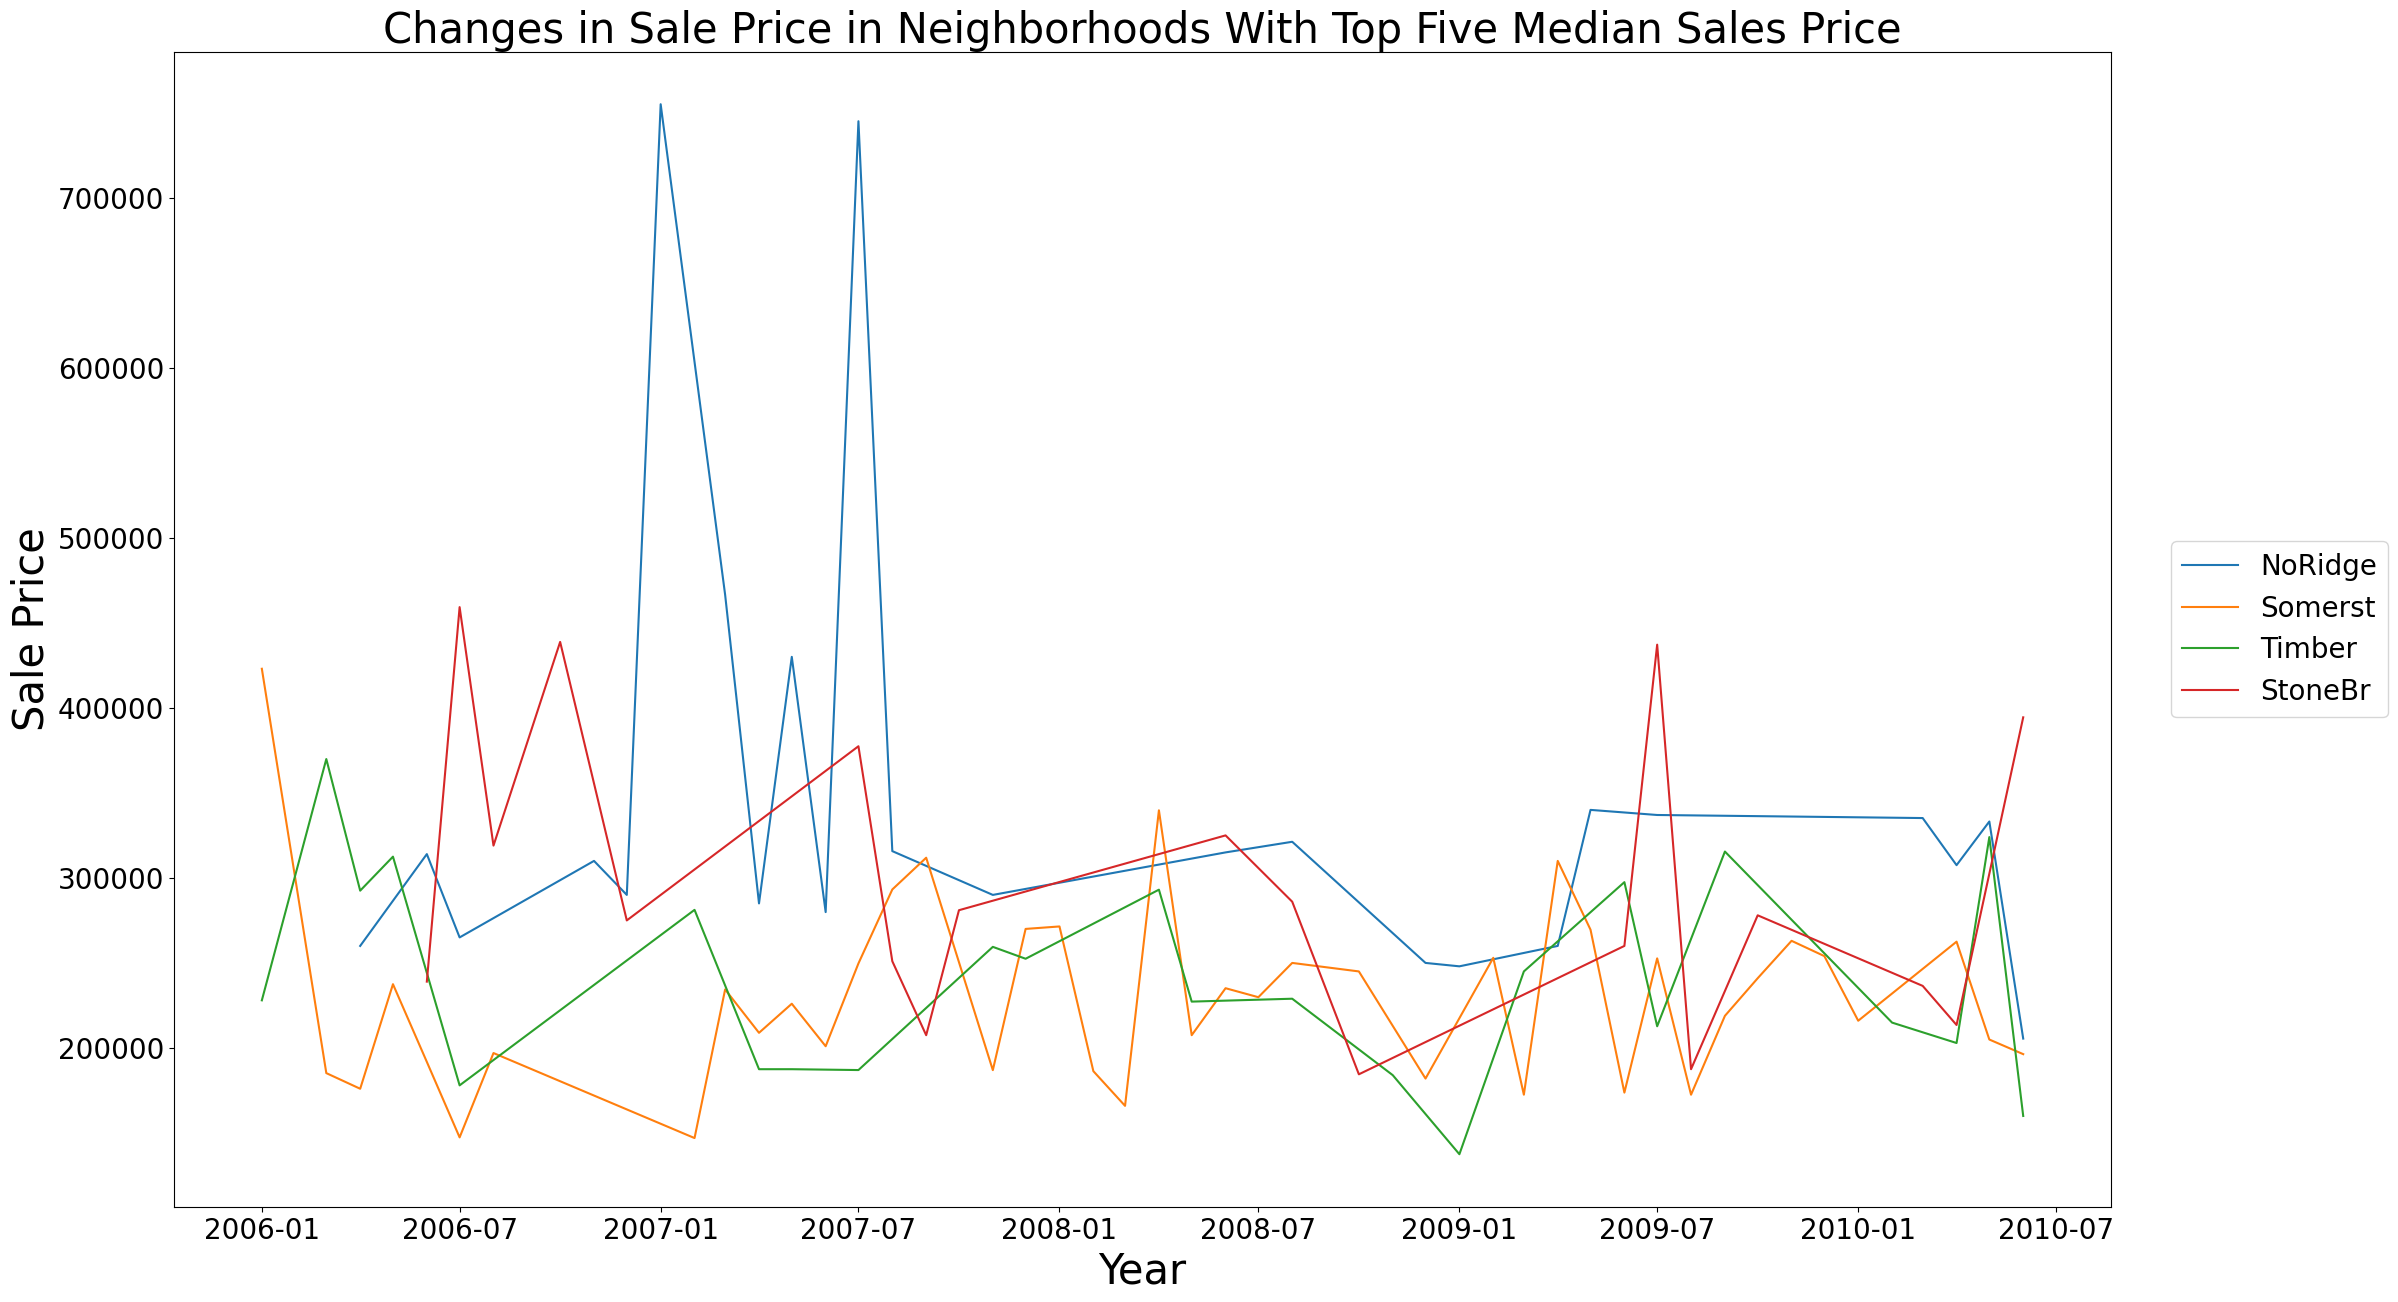

In [2319]:
# Creating figure 
plt.figure(figsize=(25,15))

# Creating plot
sns.lineplot(data=top_five_df, x='YrMoSold_dt', y='SalePrice',hue='Neighborhood',estimator='median',errorbar=None,)

# Adjusting labels
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlabel('Year',fontsize=30)
plt.ylabel('Sale Price',fontsize=30)
plt.title('Changes in Sale Price in Neighborhoods With Top Five Median Sales Price', fontsize=30)

# Display plot
plt.legend(fontsize=20, loc='right', bbox_to_anchor=(1.15,0.5))
plt.show()

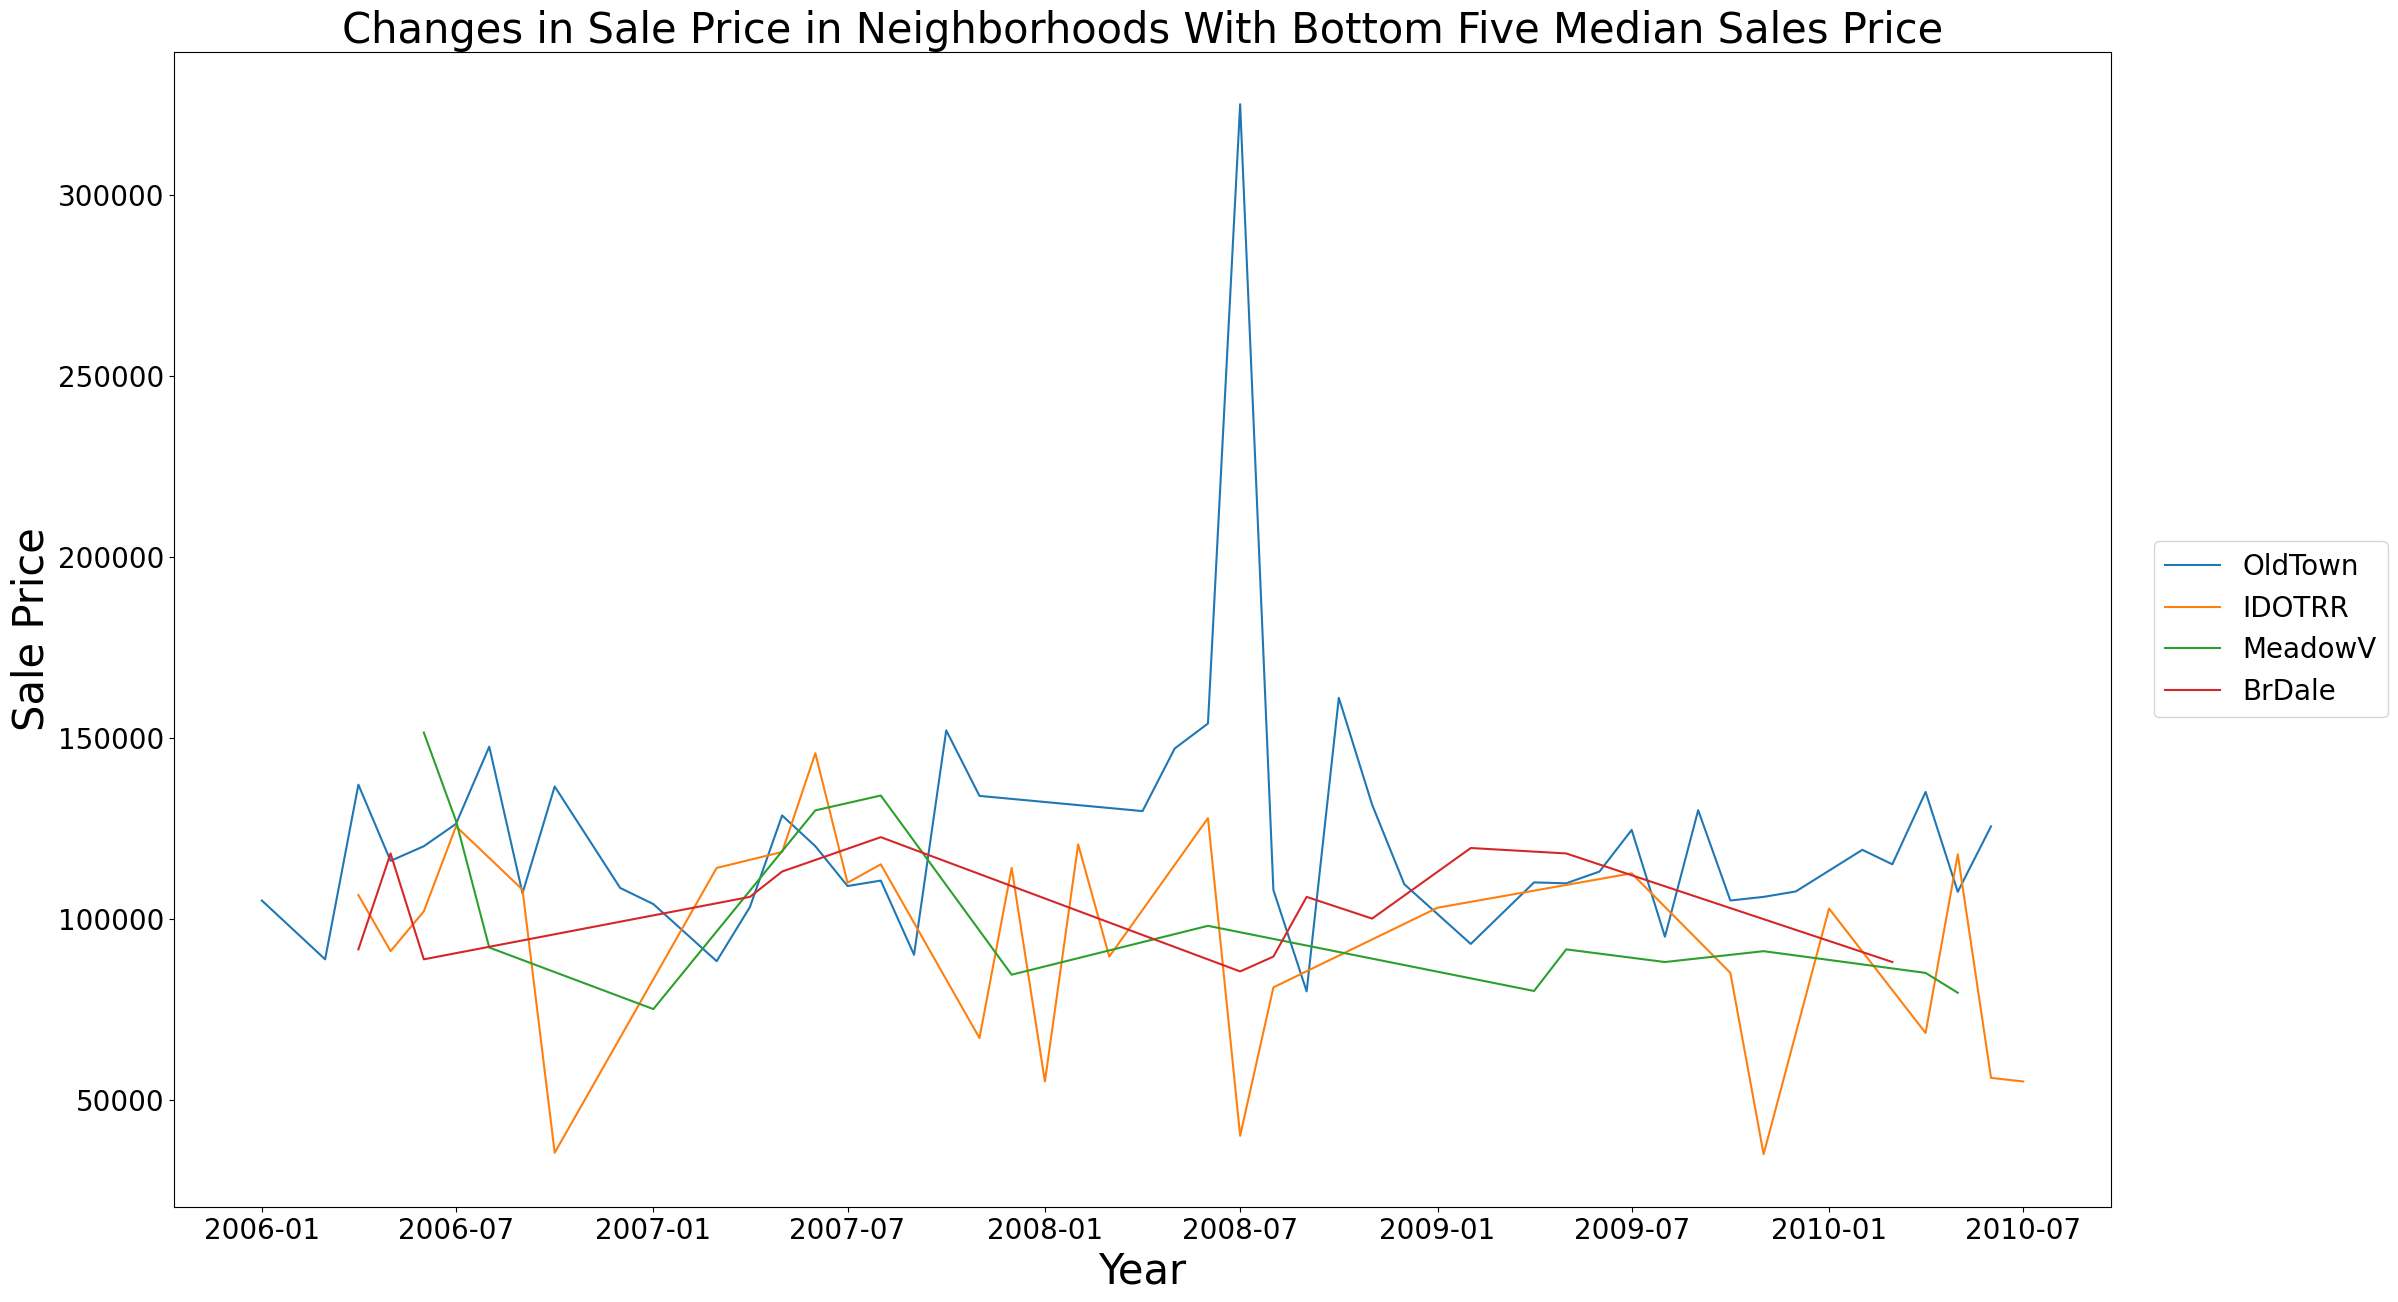

In [2320]:
# Creating figure 
plt.figure(figsize=(25,15))

# Creating plot
sns.lineplot(data=bottom_five_df, x='YrMoSold_dt', y='SalePrice',hue='Neighborhood',estimator='median',errorbar=None,)

# Adjusting labels
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlabel('Year',fontsize=30)
plt.ylabel('Sale Price',fontsize=30)
plt.title('Changes in Sale Price in Neighborhoods With Bottom Five Median Sales Price', fontsize=30)

# Display plot
plt.legend(fontsize=20, loc='right', bbox_to_anchor=(1.15,0.5))
plt.show()

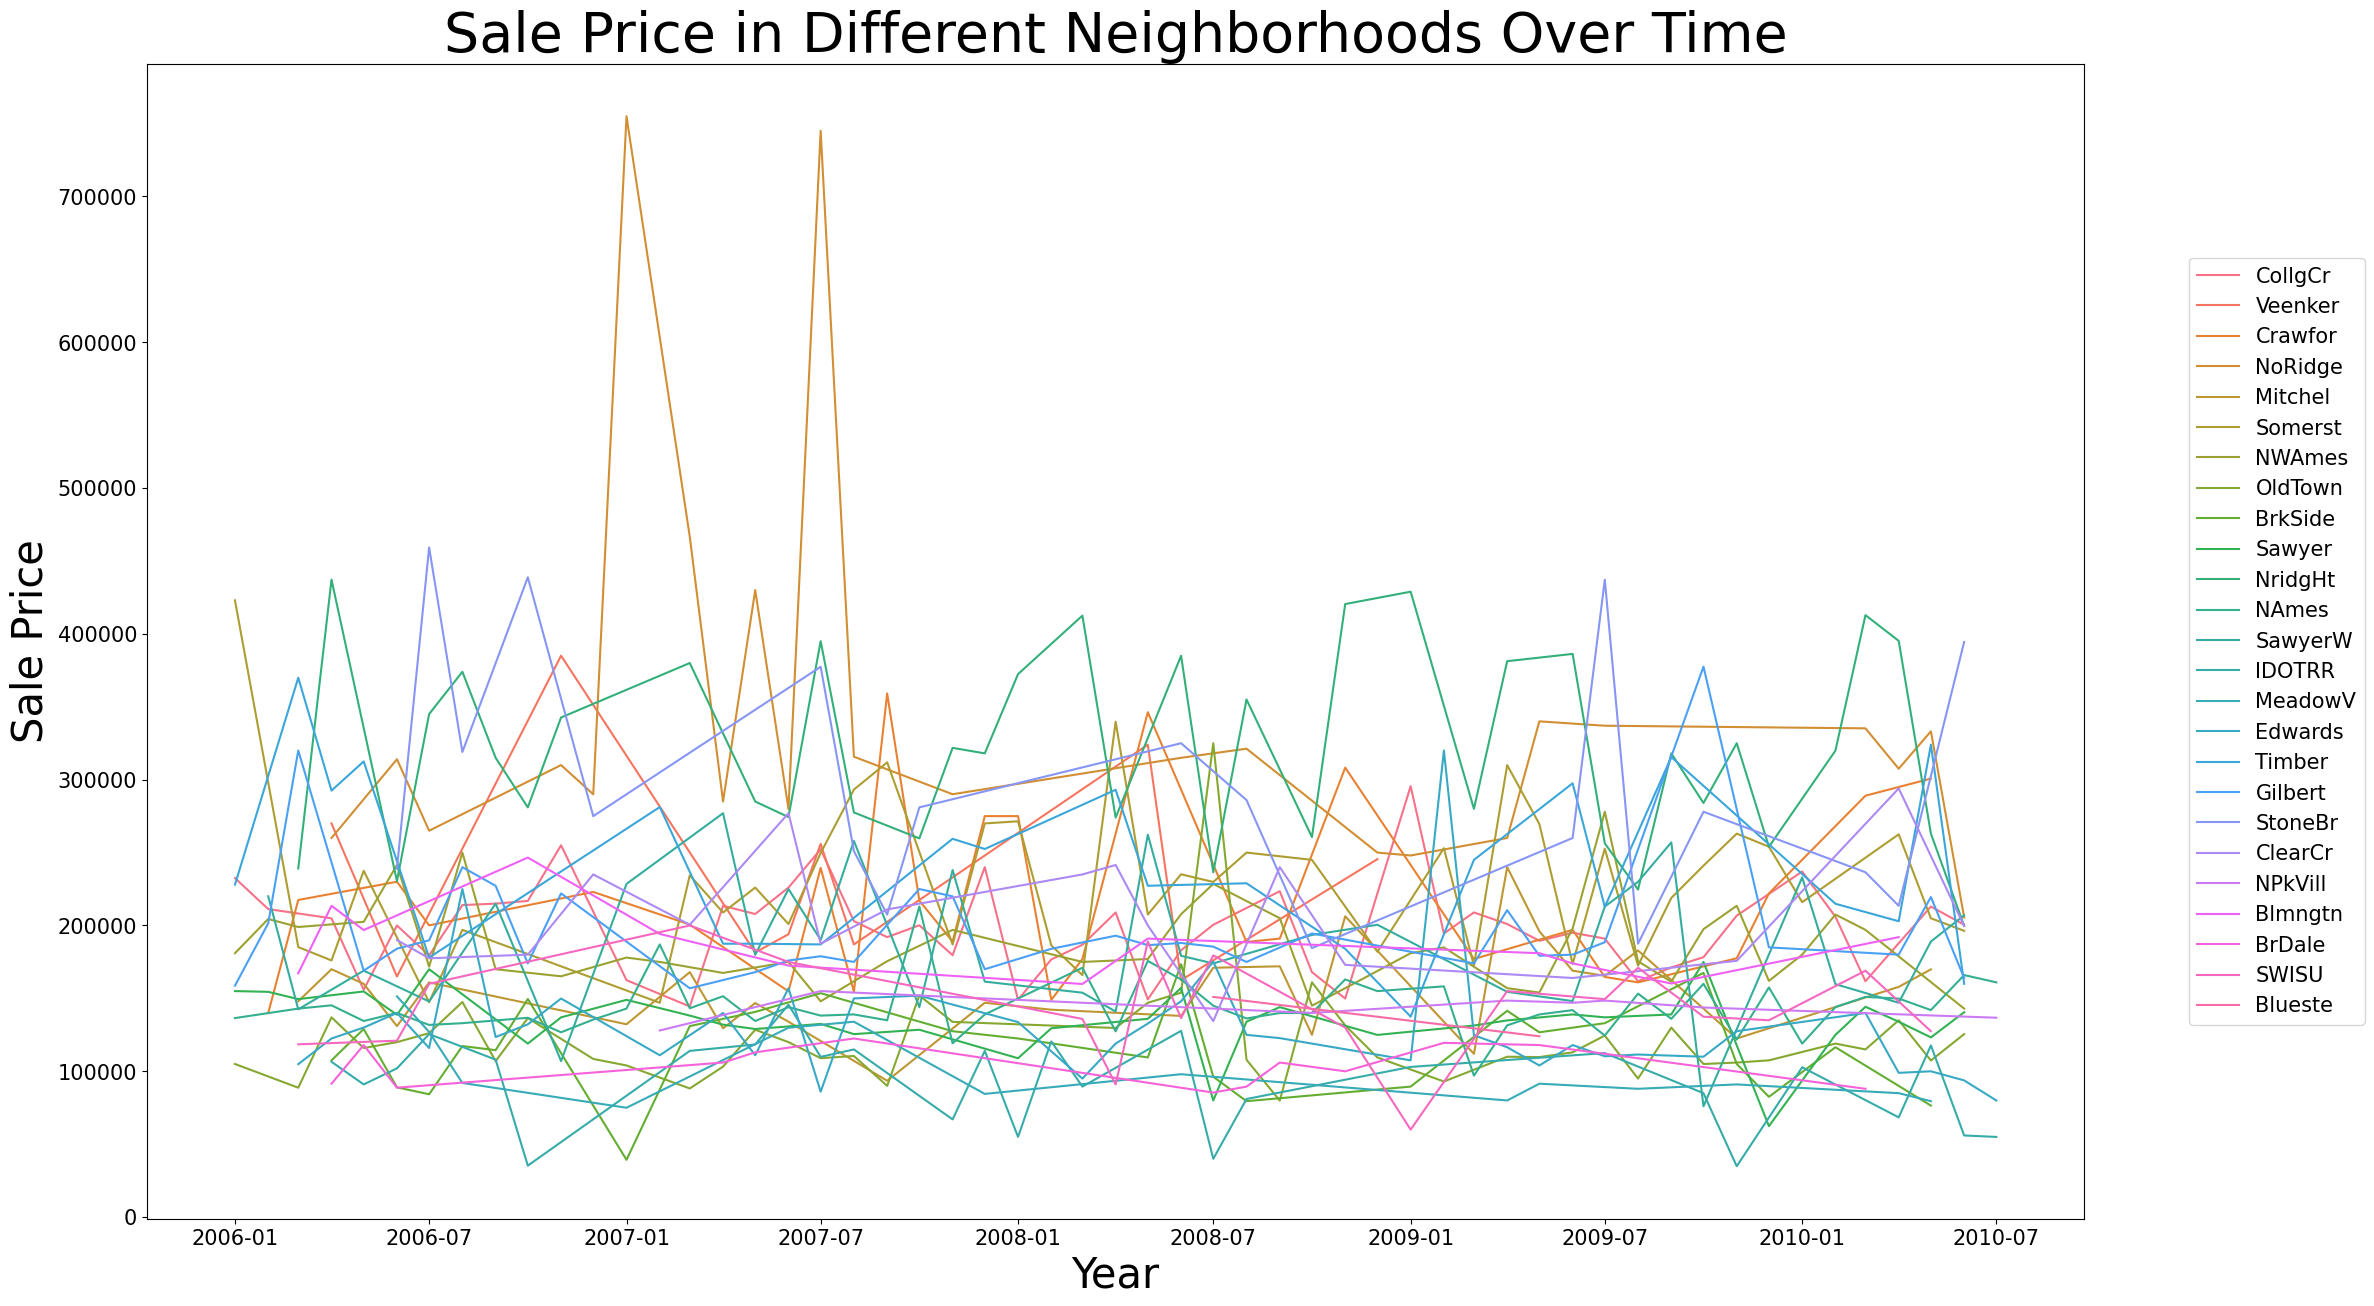

In [2321]:
# Is there temporal changes in the prices
plt.figure(figsize=(25,15))
sns.lineplot(data=df, x='YrMoSold_dt', y='SalePrice',hue='Neighborhood',estimator='median',errorbar=None,)
# Adjsuting labels
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel('Year',fontsize=30)
plt.ylabel('Sale Price',fontsize=30)
plt.title('Sale Price in Different Neighborhoods Over Time', fontsize=40)

# Display plot
plt.legend(fontsize=15, loc='right', bbox_to_anchor=(1.15,0.5))
plt.show()

From this graph, it does seem to suggest that there are trends in the sales price of neighborhoods overtime. For instance, the first line represents the neighborhood 'NridgHt'. It can be seen that in 2006 the median sold price was around 325,000 and significantly declined by 2010 to around 275,000. Other neighborhoods seem to have relatively consistent median sale price values over time, while some neighborhoods actually increased over time ('NWAmes').

In [2322]:
# Perfrom groupby analysis to see what the median sales prices of the different house style
df.groupby('HouseStyle')['SalePrice'].median().sort_values()

HouseStyle
1.5Unf    111250.0
1.5Fin    132000.0
2.5Unf    133900.0
SFoyer    135960.0
1Story    154750.0
SLvl      164500.0
2Story    190000.0
2.5Fin    194000.0
Name: SalePrice, dtype: float64

In [2323]:
df.value_counts('HouseStyle')

HouseStyle
1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: count, dtype: int64

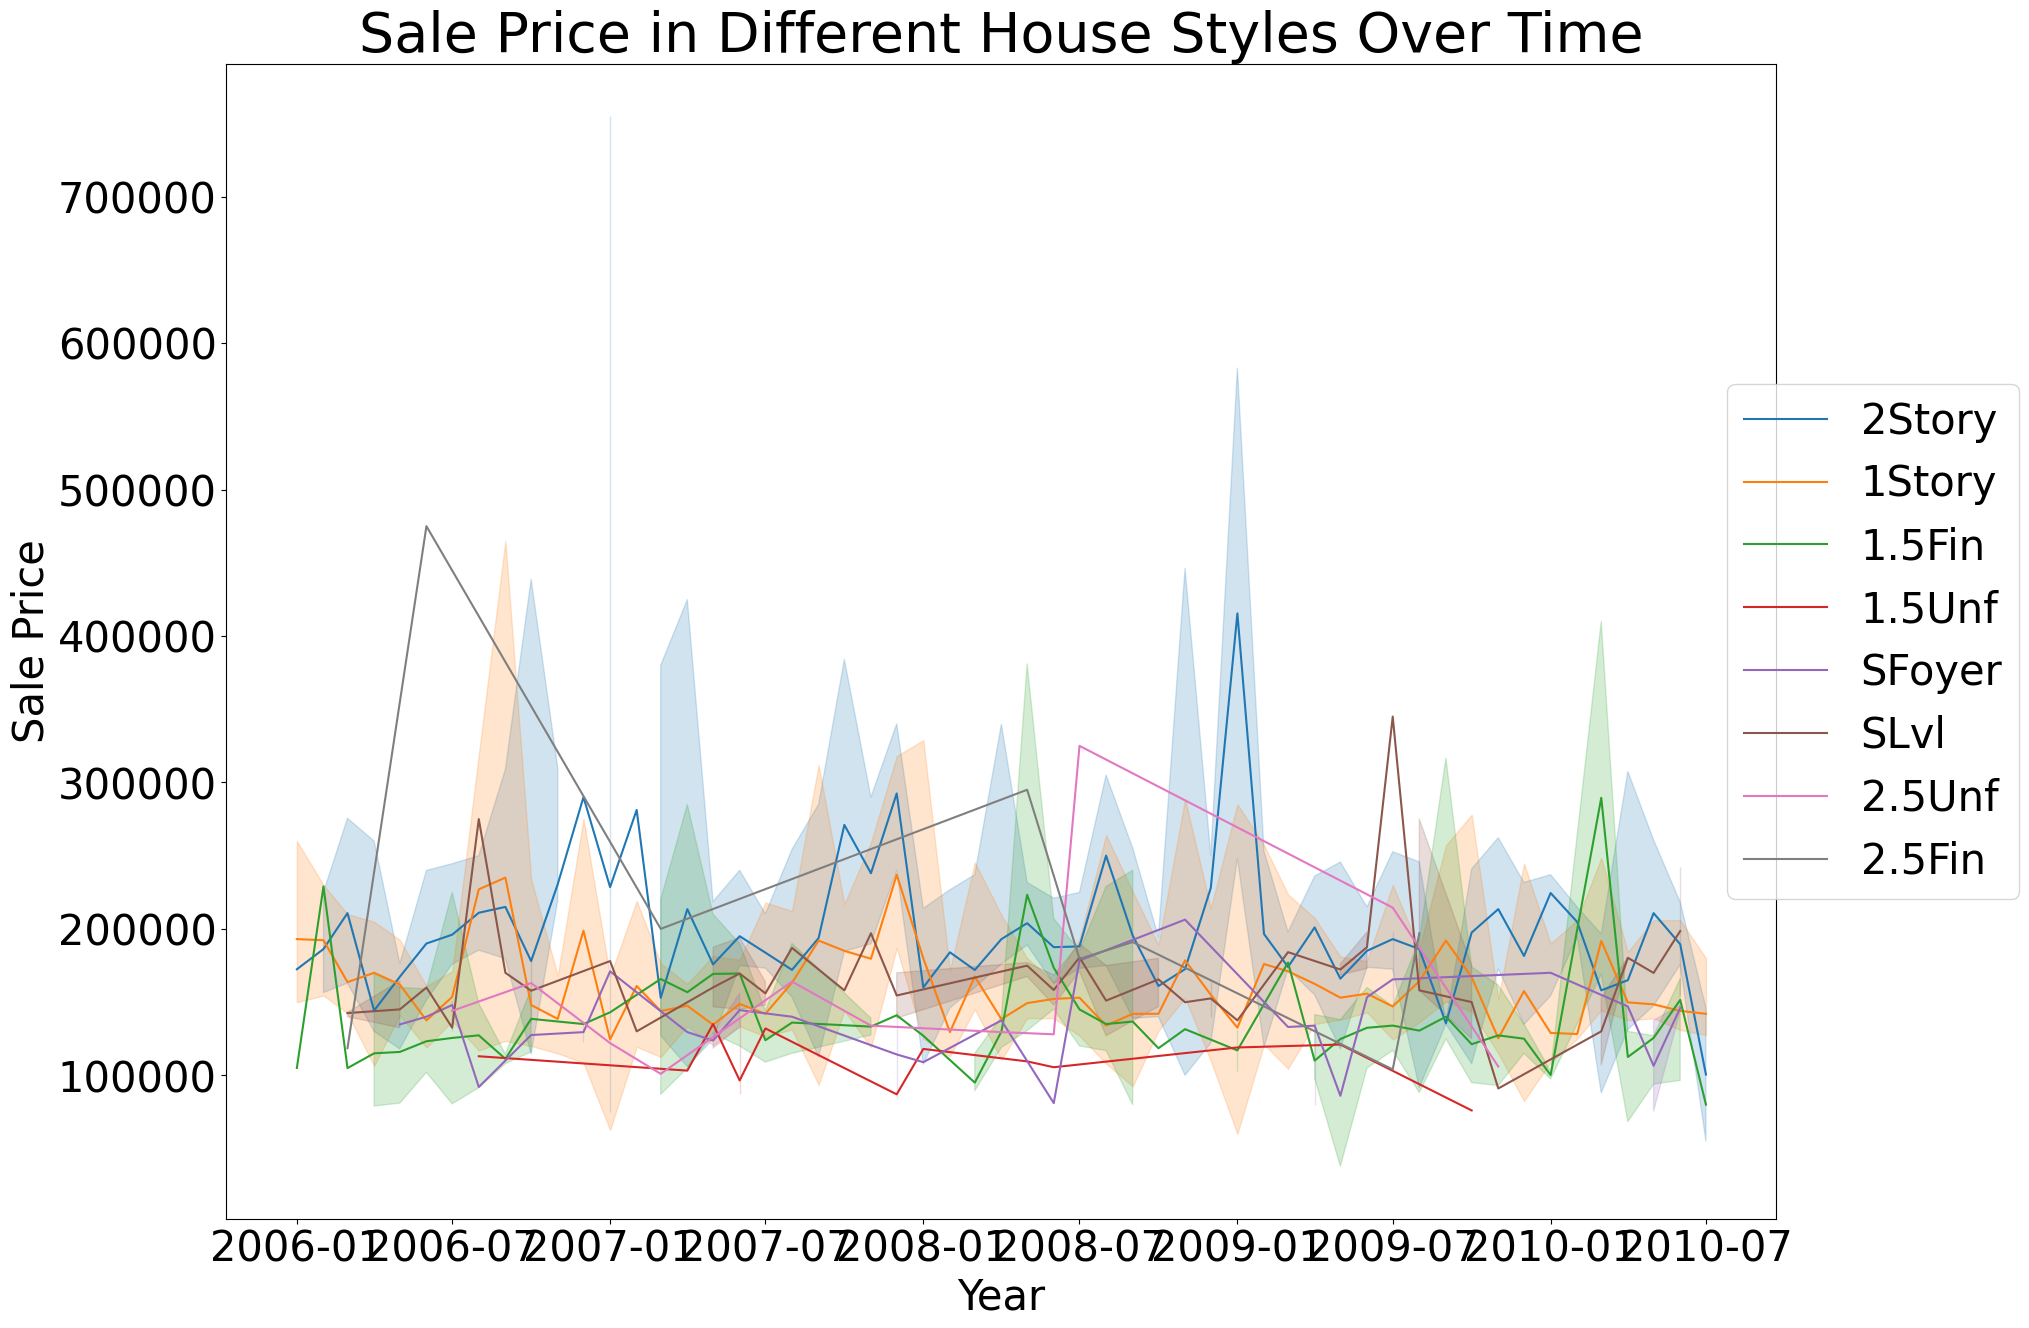

In [2324]:
# Are there temporal changes in the prices of homestyles?
plt.figure(figsize=(20,15))
sns.lineplot(data=df, x='YrMoSold_dt', y='SalePrice',hue='HouseStyle',estimator='median',)

# Adding labels
plt.xticks(size=30)
plt.yticks(size=30)
plt.xlabel('Year',fontsize=30)
plt.ylabel('Sale Price',fontsize=30)
plt.title('Sale Price in Different House Styles Over Time', fontsize=40)

# Display plot
plt.legend(fontsize=30, loc='right', bbox_to_anchor=(1.17,0.5))
plt.show()

For the most part it does seem that the property styles median prices remain relatively constant over time. We do see that the "Two and one-half story: 2nd level finished" home type started an elevated median sale price value in 2006 and then decreased and converged with the rest of the data. This could be attributed to the fact that there are not many homes of that type in this dataset. Each observation has significantly more weight than those of other home types. Thus, leading to the increased variation over time.

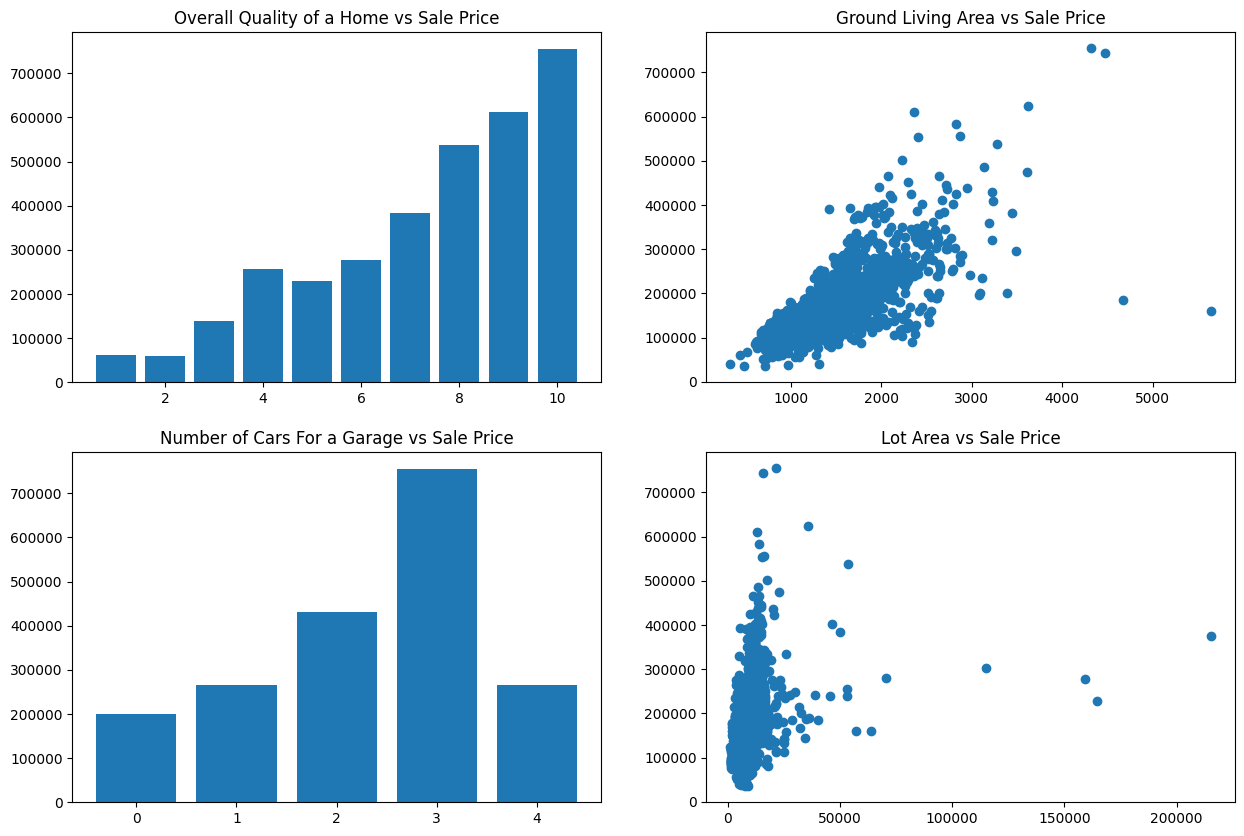

In [2325]:
# Plotting features to visualize skewness
fig,axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

# Flatten axes
axes = axes.flatten()

# Creating plots
axes[0].bar(df['OverallQual'], df['SalePrice'])
axes[1].scatter(df['GrLivArea'], df['SalePrice'])
axes[2].bar(df['GarageCars'], df['SalePrice'])
axes[3].scatter(df['LotArea'], df['SalePrice'])

# Setting Labels
axes[0].set_title('Overall Quality of a Home vs Sale Price')
axes[1].set_title('Ground Living Area vs Sale Price')
axes[2].set_title('Number of Cars For a Garage vs Sale Price')
axes[3].set_title('Lot Area vs Sale Price')

# Displaying plot
plt.show()

Overall, we see consistent trends with was was presented earlier in the correlation matrix. The quality of the property has a significant impact on the average home sale price. The ground living area has a great linear relationship with the sales price with very few points of high leverage (unusual in terms of's). The sales price of a home seems to be very sensitive to increases in lot area. 

# Transforming Categorical data and data preprocessing #

In [2326]:
import scipy.stats as stats
# Let's review if there are any features with significant skew

# Selecting numerical columns
num_cols = list(df.select_dtypes(np.number).columns)

# Removing 'MSSubClass' as it is not a true numerical feature
num_cols = [x for x in num_cols if x != 'MSSubClass'] # Note this will also serve the purpsoe for selecting numerical var for scaling prior to modeling

statistics = {}

for column in num_cols:
    stats_dict = {
        'Mean': df[column].mean(),
        'Standard Deviation': df[column].std(),
        'Max': df[column].max(),
        'Min': df[column].min(),
        'Skewness': stats.skew(df[column], bias=False),
        'Kurtosis': stats.kurtosis(df[column], bias=False)
    }
    statistics[column] = stats_dict

# Creating a dataframe from the dictionary 
statistics_df = pd.DataFrame(statistics).T
# Display
statistics_df

,Mean,Standard Deviation,Max,Min,Skewness,Kurtosis
LotArea,10516.828082,9981.264932,215245.0,1300.0,12.207688,203.243271
OverallQual,6.099315,1.382997,10.0,1.0,0.216944,0.096293
OverallCond,5.575342,1.112799,9.0,1.0,0.693067,1.106413
MasVnrArea,103.117123,180.731373,1600.0,0.0,2.677616,10.141416
BsmtFinSF1,443.639726,456.098091,5644.0,0.0,1.685503,11.118236
BsmtFinSF2,46.549315,161.319273,1474.0,0.0,4.255261,20.113338
BsmtUnfSF,567.240411,441.866955,2336.0,0.0,0.920268,0.474994
TotalBsmtSF,1057.429452,438.705324,6110.0,0.0,1.524255,13.250483
1stFlrSF,1162.626712,386.587738,4692.0,334.0,1.376757,5.745841
2ndFlrSF,346.992466,436.528436,2065.0,0.0,0.813030,-0.553464


There are some variables like kitchens above ground that do have a significant skew. However, as these variables are discrete variables I do not see a reason to transform them as it reduces the interpretability of an analysis. Additionally, it seems that some variables such as pool area are significantly skewed due to a substantial amount of homes not containing a pool, and one outlier containing 738 square feet of a pool. I don't think transforming such a variable will change the distribution, thus I will leave it alone.

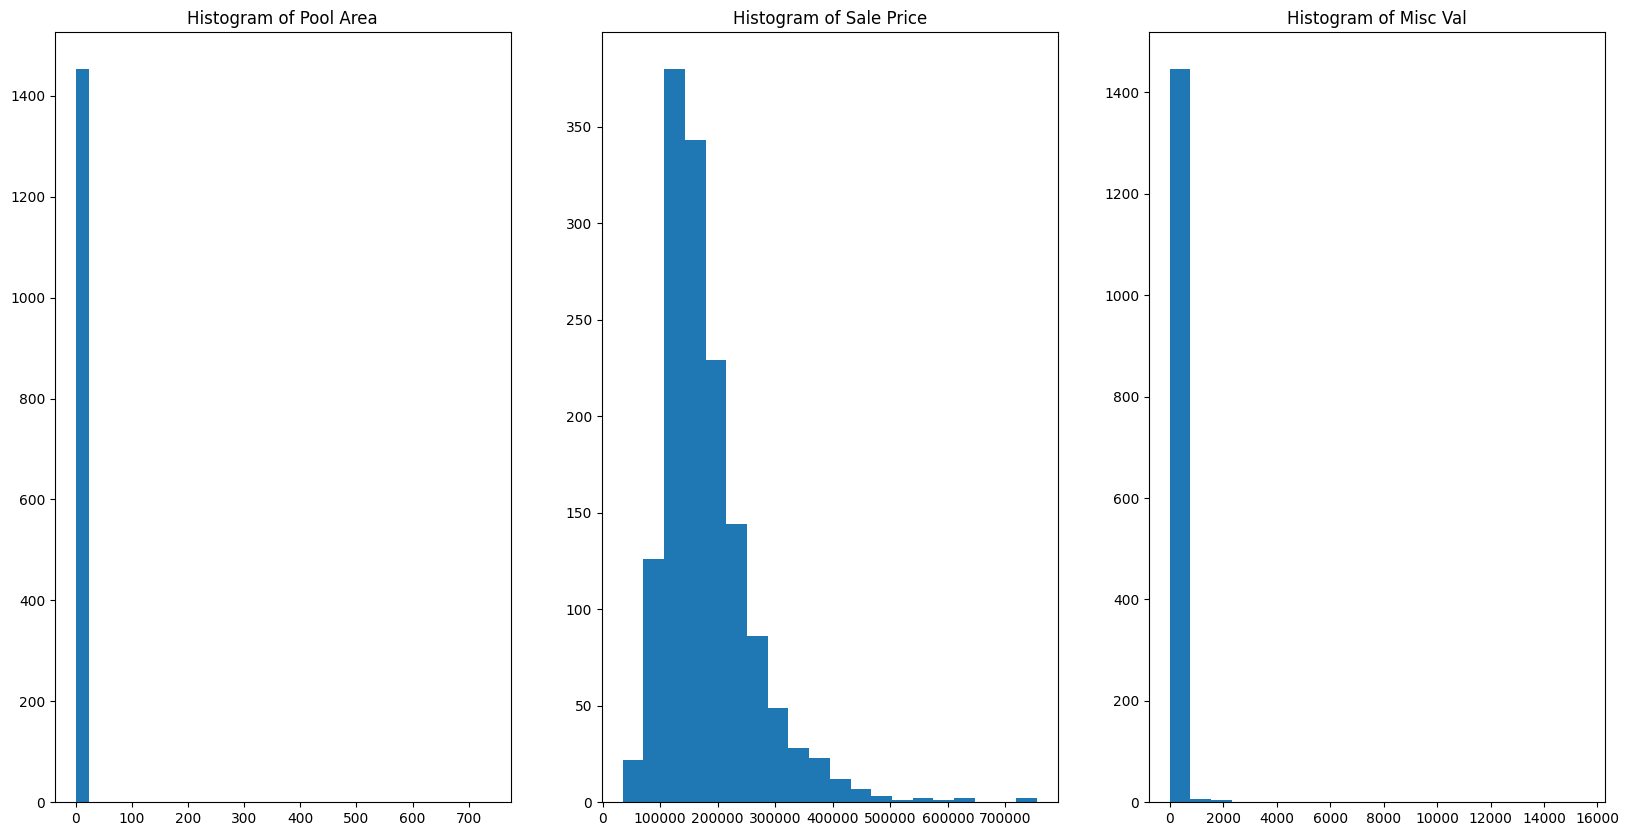

In [2327]:
# Plotting features to visualize skewness
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(20,10))

# Flatten axes
axes = axes.flatten()

# Creating plots
axes[0].hist(df['PoolArea'],bins=30)
axes[1].hist(df['SalePrice'],bins=20)
axes[2].hist(df['MiscVal'],bins=20)

# Setting Labels
axes[0].set_title('Histogram of Pool Area')
axes[1].set_title('Histogram of Sale Price')
axes[2].set_title('Histogram of Misc Val')

# Displaying plot
plt.show()


In [2328]:
# Selecting skewed variabels
skew_col = ['LotArea', 'SalePrice']

In [2329]:
# Transforming variables
for x in skew_col:
    df[x] = np.log(df[x])

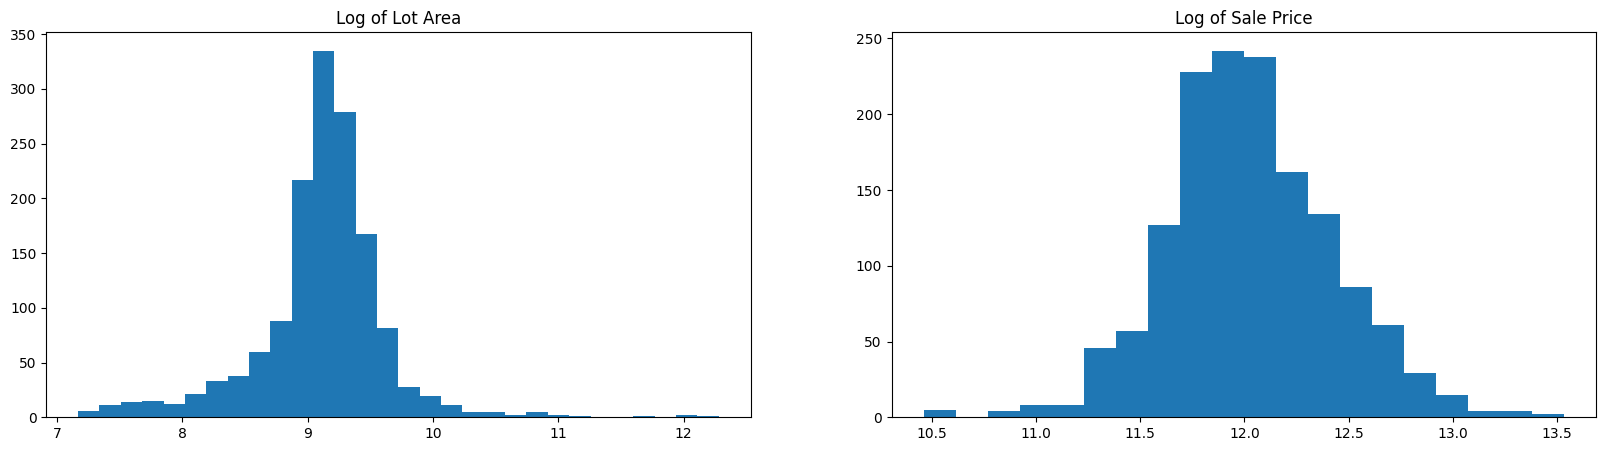

In [2330]:
# Plotting features to visualize skewness
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

# Flatten axes
axes = axes.flatten()

# Creating plots
axes[0].hist(df['LotArea'],bins=30)
axes[1].hist(df['SalePrice'],bins=20)

# Setting Labels
axes[0].set_title('Log of Lot Area')
axes[1].set_title('Log of Sale Price')

# Displaying plot
plt.show()


In [2331]:
# Calculating the median property value
med = df['SalePrice'].median()

# Display
print('The median property sale price is $',med)

The median property sale price is $ 12.0015054797889


In [2332]:
# Viewing categorical features
df.select_dtypes(include='object').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 45 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MSZoning      1460 non-null   object
 1   Street        1460 non-null   object
 2   Alley         1460 non-null   object
 3   LotShape      1460 non-null   object
 4   LandContour   1460 non-null   object
 5   Utilities     1460 non-null   object
 6   LotConfig     1460 non-null   object
 7   LandSlope     1460 non-null   object
 8   Neighborhood  1460 non-null   object
 9   Condition1    1460 non-null   object
 10  Condition2    1460 non-null   object
 11  BldgType      1460 non-null   object
 12  HouseStyle    1460 non-null   object
 13  YearBuilt     1460 non-null   object
 14  YearRemodAdd  1460 non-null   object
 15  RoofStyle     1460 non-null   object
 16  RoofMatl      1460 non-null   object
 17  Exterior1st   1460 non-null   object
 18  Exterior2nd   1460 non-null   object
 19  MasVnr

Most of the data is nominal, however, there are a few variables that take on a ordinal structure. Therefore, ordinal variables will need to be taken care of in a different manner to preserve the order.

In [2333]:
# Viewing features
df.select_dtypes(include='object').head()

C:\Users\cocob\OneDrive\Documents\Boston College\Spring 2024\GLM\Virtual Environment\glm_general\Lib\site-packages\IPython\core\displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,MoSold,YrSold
0,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,None,Attchd,RFn,TA,TA,Y,None,None,None,2,2008
1,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,None,None,None,5,2007
2,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,None,None,None,9,2008
3,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,None,None,None,2,2006
4,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,None,None,None,12,2008


In [2334]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

# Creating a list of the variables for each encoding method

# Obtaining a list of all the 'object' variables
cat_list = list(df.select_dtypes('object').columns)

# Obtaining a list of all the nominal categorical variables
dummy_list = [var for var in cat_list 
              if var != 'ExterQual' 
              and var != 'ExterCond' 
              and var != 'BsmtQual' 
              and var != 'BsmtCond' 
              and var != 'GarageQual'
             and var!= 'GarageCond']

# Obtaining a list of all the ordinal variables
ordin_list = ['ExterQual','ExterCond','BsmtQual', 'BsmtCond','GarageQual','GarageCond']



In [2335]:
# Encoding Nominal data

# Instantiating classes
dummycoder = OneHotEncoder(sparse_output=False)

# Encode 
encoded_vars_dummy = dummycoder.fit_transform(df[dummy_list])

# Create a dataframe with encoded data (Dummy variables first)
dummy_encoded_df = pd.DataFrame(encoded_vars_dummy, columns=dummycoder.get_feature_names_out(dummy_list))

# Create a list of dummy variables in case for future referance
dummy_encoded_col = list(dummy_encoded_df.columns)

# Used code from our General Linear Model class to assist with encoding 
# https://1drv.ms/f/c/29eb65febd53f90e/EusRKDiigIROtXVxEoK2jzYByvuDfrC4Oix_9YBVaQn2pw?e=yo2Xfn

In [2336]:
# Merge encoded variables back to df
df_merge = pd.merge(df,dummy_encoded_df, right_index=True, left_index=True)

# Checking dummy variables align
print(df_merge.loc[0:5, 'LandContour':'LotConfig'])
print(df_merge.loc[0:5,'LandContour_Bnk':'LotConfig_Inside'])

  LandContour Utilities LotConfig
0         Lvl    AllPub    Inside
1         Lvl    AllPub       FR2
2         Lvl    AllPub    Inside
3         Lvl    AllPub    Corner
4         Lvl    AllPub       FR2
5         Lvl    AllPub    Inside
   LandContour_Bnk  LandContour_HLS  LandContour_Low  LandContour_Lvl  \
0              0.0              0.0              0.0              1.0   
1              0.0              0.0              0.0              1.0   
2              0.0              0.0              0.0              1.0   
3              0.0              0.0              0.0              1.0   
4              0.0              0.0              0.0              1.0   
5              0.0              0.0              0.0              1.0   

   Utilities_AllPub  Utilities_NoSeWa  LotConfig_Corner  LotConfig_CulDSac  \
0               1.0               0.0               0.0                0.0   
1               1.0               0.0               0.0                0.0   
2               

It does seem like the dummy variables worked correctly. Let's continue with the ordinal values

In [2337]:
# Reviewing responses of each ordinal variable
for x in ordin_list:
    print(df[x].value_counts())

ExterQual
TA    906
Gd    488
Ex     52
Fa     14
Name: count, dtype: int64
ExterCond
TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: count, dtype: int64
BsmtQual
TA      649
Gd      618
Ex      121
None     37
Fa       35
Name: count, dtype: int64
BsmtCond
TA      1311
Gd        65
Fa        45
None      37
Po         2
Name: count, dtype: int64
GarageQual
TA      1311
None      81
Fa        48
Gd        14
Ex         3
Po         3
Name: count, dtype: int64
GarageCond
TA      1326
None      81
Fa        35
Gd         9
Po         7
Ex         2
Name: count, dtype: int64


We have an issue where some responses are none. This is a issue becuase ordinal values assign values with ranking to give unique observations order. If 'None' were encoded as '0' for garage quality, then this implies that it is 'less' than poor quality garages. As this does not make sense we will correct for this by denoting which properties are missing garages and basements.

In [2338]:
# Creating a function to denote which properties have a basement and a garage
def encode(data):
    if data == 'None':
        return 0
    else:
        return 1

# Creating Binary Variable for basement
df_merge['Has_Bsmt'] = df_merge['BsmtCond'].apply(encode)

# Creating binary variable for Garage
df_merge['Has_Garage'] = df_merge['GarageCond'].apply(encode)        
    

In [2339]:
# Viewing transformation for garage
print(df_merge[['Has_Garage','GarageCond']].head())

# Filtering df
filt = df_merge[df_merge['Has_Garage'] == 0]
print(filt[['Has_Garage','GarageCond']].head())


   Has_Garage GarageCond
0           1         TA
1           1         TA
2           1         TA
3           1         TA
4           1         TA
    Has_Garage GarageCond
39           0       None
48           0       None
78           0       None
88           0       None
89           0       None


In [2340]:
# Viewing transformation for basement
print(df_merge[['Has_Bsmt','BsmtCond']].head())

# Filtering df
filt = df_merge[df_merge['Has_Bsmt'] == 0]
print(filt[['Has_Bsmt','BsmtCond']].head())

   Has_Bsmt BsmtCond
0         1       TA
1         1       TA
2         1       TA
3         1       Gd
4         1       TA
     Has_Bsmt BsmtCond
17          0     None
39          0     None
90          0     None
102         0     None
156         0     None


Transformations have worked. Now, we can properly encode the data ordinally

In [2341]:
# Order for ordinal variables
order_list_wo_none = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
order_list_w_none = ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_list_wo_po = ['None', 'Fa', 'TA', 'Gd', 'Ex']
order_list_wo_po_none = ['Fa', 'TA', 'Gd', 'Ex']
order_list_wo_ex = ['None', 'Po', 'Fa', 'TA', 'Gd']


# Instantiating class
ordinal_encoder = OrdinalEncoder(categories=[order_list_wo_po_none,
                                              order_list_wo_none,
                                              order_list_wo_po,
                                              order_list_wo_ex,
                                              order_list_w_none,
                                              order_list_w_none])

# Transforming ordinal variables
encoded_var_ordinal = ordinal_encoder.fit_transform(df_merge[ordin_list])

# Creating a dataframe from ordinal valeus
ordinal_encoded_df = pd.DataFrame(encoded_var_ordinal, columns=ordinal_encoder.get_feature_names_out(ordin_list))

# Creating a list of column variabels just in case for future referance 
ordinal_encoded_col = list(ordinal_encoded_df.columns)

# Merging with df_merge
df_merge_2 = pd.merge(ordinal_encoded_df, df_merge,left_index=True, right_index=True)

In [2342]:
# Viewing encoded dataframe
ordinal_encoded_df

,ExterQual,ExterCond,BsmtQual,BsmtCond,GarageQual,GarageCond
0,2.0,2.0,3.0,3.0,3.0,3.0
1,1.0,2.0,3.0,3.0,3.0,3.0
2,2.0,2.0,3.0,3.0,3.0,3.0
3,1.0,2.0,2.0,4.0,3.0,3.0
4,2.0,2.0,3.0,3.0,3.0,3.0
...,...,...,...,...,...,...
1455,1.0,2.0,3.0,3.0,3.0,3.0
1456,1.0,2.0,3.0,3.0,3.0,3.0
1457,3.0,3.0,2.0,4.0,3.0,3.0
1458,1.0,2.0,2.0,3.0,3.0,3.0


In [2343]:
# Viewing merged df
df_merge_2.head()

,ExterQual_x,ExterCond_x,BsmtQual_x,BsmtCond_x,GarageQual_x,GarageCond_x,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual_y,ExterCond_y,Foundation,BsmtQual_y,BsmtCond_y,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual_y,GarageCond_y,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SalePrice,YearBuilt_dt,YearRemodAdd_dt,YrMoSold_dt,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,YearBuilt_1872,YearBuilt_1875,YearBuilt_1880,YearBuilt_1882,YearBuilt_1885,YearBuilt_1890,YearBuilt_1892,YearBuilt_1893,YearBuilt_1898,YearBuilt_1900,YearBuilt_1904,YearBuilt_1905,YearBuilt_1906,YearBuilt_1908,YearBuilt_1910,YearBuilt_1911,YearBuilt_1912,YearBuilt_1913,YearBuilt_1914,YearBuilt_1915,YearBuilt_1916,YearBuilt_1917,YearBuilt_1918,YearBuilt_1919,YearBuilt_1920,YearBuilt_1921,YearBuilt_1922,YearBuilt_1923,YearBuilt_1924,YearBuilt_1925,YearBuilt_1926,YearBuilt_1927,YearBuilt_1928,YearBuilt_1929,YearBuilt_1930,YearBuilt_1931,YearBuilt_1932,YearBuilt_1934,YearBuilt_1935,YearBuilt_1936,YearBuilt_1937,YearBuilt_1938,YearBuilt_1939,YearBuilt_1940,YearBuilt_1941,YearBuilt_1942,YearBuilt_1945,YearBuilt_1946,YearBuilt_1947,YearBuilt_1948,YearBuilt_1949,YearBuilt_1950,YearBuilt_1951,YearBuilt_1952,YearBuilt_1953,YearBuilt_1954,YearBuilt_1955,YearBuilt_1956,YearBuilt_1957,YearBuilt_1958,YearBuilt_1959,YearBuilt_1960,YearBuilt_1961,YearBuilt_1962,YearBuilt_1963,YearBuilt_1964,YearBuilt_1965,YearBuilt_1966,YearBuilt_1967,YearBuilt_1968,YearBuilt_1969,YearBuilt_1970,YearBuilt_1971,YearBuilt_1972,YearBuilt_1973,YearBuilt_1974,YearBuilt_1975,YearBuilt_1976,YearBuilt_1977,YearBuilt_1978,YearBuilt_1979,YearBuilt_1980,YearBuilt_1981,YearBuilt_1982,YearBuilt_1983,YearBuilt_1984,YearBuilt_1985,YearBuilt_1986,YearBuilt_1987,YearBuilt_1988,YearBuilt_1989,YearBuilt_1990,YearBuilt_1991,YearBuilt_1992,YearBuilt_1993,YearBuilt_1994,YearBuilt_1995,YearBuilt_1996,YearBuilt_1997,YearBuilt_1998,YearBuilt_1999,YearBuilt_2000,YearBuilt_2001,YearBuilt_2002,YearBuilt_2003,YearBuilt_2004,YearBuilt_2005,YearBuilt_2006,YearBuilt_2007,YearBuilt_2008,

In [2344]:
# Checking df encoded data correctly
print(df_merge_2.loc[0:5, 'ExterQual_x':'GarageCond_x'])

# Reassigning ordinal list
ordin_list = ['ExterQual_y', 'ExterCond_y', 'BsmtQual_y', 'BsmtCond_y', 'GarageQual_y', 'GarageCond_y']

# Displaying orginal values for comparison
print(df_merge_2[ordin_list].head())


   ExterQual_x  ExterCond_x  BsmtQual_x  BsmtCond_x  GarageQual_x  \
0          2.0          2.0         3.0         3.0           3.0   
1          1.0          2.0         3.0         3.0           3.0   
2          2.0          2.0         3.0         3.0           3.0   
3          1.0          2.0         2.0         4.0           3.0   
4          2.0          2.0         3.0         3.0           3.0   
5          1.0          2.0         3.0         3.0           3.0   

   GarageCond_x  
0           3.0  
1           3.0  
2           3.0  
3           3.0  
4           3.0  
5           3.0  
  ExterQual_y ExterCond_y BsmtQual_y BsmtCond_y GarageQual_y GarageCond_y
0          Gd          TA         Gd         TA           TA           TA
1          TA          TA         Gd         TA           TA           TA
2          Gd          TA         Gd         TA           TA           TA
3          TA          TA         TA         Gd           TA           TA
4          Gd       

Looks appropriate

In [2345]:
# Renaming tranformed dataframe for tracking purposes
df_transformed = df_merge_2.copy()

# Displaying data
df_transformed.head()

,ExterQual_x,ExterCond_x,BsmtQual_x,BsmtCond_x,GarageQual_x,GarageCond_x,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual_y,ExterCond_y,Foundation,BsmtQual_y,BsmtCond_y,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual_y,GarageCond_y,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SalePrice,YearBuilt_dt,YearRemodAdd_dt,YrMoSold_dt,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,YearBuilt_1872,YearBuilt_1875,YearBuilt_1880,YearBuilt_1882,YearBuilt_1885,YearBuilt_1890,YearBuilt_1892,YearBuilt_1893,YearBuilt_1898,YearBuilt_1900,YearBuilt_1904,YearBuilt_1905,YearBuilt_1906,YearBuilt_1908,YearBuilt_1910,YearBuilt_1911,YearBuilt_1912,YearBuilt_1913,YearBuilt_1914,YearBuilt_1915,YearBuilt_1916,YearBuilt_1917,YearBuilt_1918,YearBuilt_1919,YearBuilt_1920,YearBuilt_1921,YearBuilt_1922,YearBuilt_1923,YearBuilt_1924,YearBuilt_1925,YearBuilt_1926,YearBuilt_1927,YearBuilt_1928,YearBuilt_1929,YearBuilt_1930,YearBuilt_1931,YearBuilt_1932,YearBuilt_1934,YearBuilt_1935,YearBuilt_1936,YearBuilt_1937,YearBuilt_1938,YearBuilt_1939,YearBuilt_1940,YearBuilt_1941,YearBuilt_1942,YearBuilt_1945,YearBuilt_1946,YearBuilt_1947,YearBuilt_1948,YearBuilt_1949,YearBuilt_1950,YearBuilt_1951,YearBuilt_1952,YearBuilt_1953,YearBuilt_1954,YearBuilt_1955,YearBuilt_1956,YearBuilt_1957,YearBuilt_1958,YearBuilt_1959,YearBuilt_1960,YearBuilt_1961,YearBuilt_1962,YearBuilt_1963,YearBuilt_1964,YearBuilt_1965,YearBuilt_1966,YearBuilt_1967,YearBuilt_1968,YearBuilt_1969,YearBuilt_1970,YearBuilt_1971,YearBuilt_1972,YearBuilt_1973,YearBuilt_1974,YearBuilt_1975,YearBuilt_1976,YearBuilt_1977,YearBuilt_1978,YearBuilt_1979,YearBuilt_1980,YearBuilt_1981,YearBuilt_1982,YearBuilt_1983,YearBuilt_1984,YearBuilt_1985,YearBuilt_1986,YearBuilt_1987,YearBuilt_1988,YearBuilt_1989,YearBuilt_1990,YearBuilt_1991,YearBuilt_1992,YearBuilt_1993,YearBuilt_1994,YearBuilt_1995,YearBuilt_1996,YearBuilt_1997,YearBuilt_1998,YearBuilt_1999,YearBuilt_2000,YearBuilt_2001,YearBuilt_2002,YearBuilt_2003,YearBuilt_2004,YearBuilt_2005,YearBuilt_2006,YearBuilt_2007,YearBuilt_2008,

# Modeling #

For this section I received assistance from code utlizted in our GLM course. I have provided a link below as a citation.

https://1drv.ms/f/c/29eb65febd53f90e/EusRKDiigIROtXVxEoK2jzYByvuDfrC4Oix_9YBVaQn2pw?e=yo2Xfn

In [2346]:
# Importing appropriate packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2347]:
# Drop categorical variables that have been encoded & datetime objects
df_transformed = df_transformed.drop(dummy_list, axis=1)
df_transformed = df_transformed.drop(ordin_list, axis=1)
df_transformed = df_transformed.drop(temporal_features, axis=1)


In [2348]:
# View dataframe
df_transformed.head()

,ExterQual_x,ExterCond_x,BsmtQual_x,BsmtCond_x,GarageQual_x,GarageCond_x,MSSubClass,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,YearBuilt_1872,YearBuilt_1875,YearBuilt_1880,YearBuilt_1882,YearBuilt_1885,YearBuilt_1890,YearBuilt_1892,YearBuilt_1893,YearBuilt_1898,YearBuilt_1900,YearBuilt_1904,YearBuilt_1905,YearBuilt_1906,YearBuilt_1908,YearBuilt_1910,YearBuilt_1911,YearBuilt_1912,YearBuilt_1913,YearBuilt_1914,YearBuilt_1915,YearBuilt_1916,YearBuilt_1917,YearBuilt_1918,YearBuilt_1919,YearBuilt_1920,YearBuilt_1921,YearBuilt_1922,YearBuilt_1923,YearBuilt_1924,YearBuilt_1925,YearBuilt_1926,YearBuilt_1927,YearBuilt_1928,YearBuilt_1929,YearBuilt_1930,YearBuilt_1931,YearBuilt_1932,YearBuilt_1934,YearBuilt_1935,YearBuilt_1936,YearBuilt_1937,YearBuilt_1938,YearBuilt_1939,YearBuilt_1940,YearBuilt_1941,YearBuilt_1942,YearBuilt_1945,YearBuilt_1946,YearBuilt_1947,YearBuilt_1948,YearBuilt_1949,YearBuilt_1950,YearBuilt_1951,YearBuilt_1952,YearBuilt_1953,YearBuilt_1954,YearBuilt_1955,YearBuilt_1956,YearBuilt_1957,YearBuilt_1958,YearBuilt_1959,YearBuilt_1960,YearBuilt_1961,YearBuilt_1962,YearBuilt_1963,YearBuilt_1964,YearBuilt_1965,YearBuilt_1966,YearBuilt_1967,YearBuilt_1968,YearBuilt_1969,YearBuilt_1970,YearBuilt_1971,YearBuilt_1972,YearBuilt_1973,YearBuilt_1974,YearBuilt_1975,YearBuilt_1976,YearBuilt_1977,YearBuilt_1978,YearBuilt_1979,YearBuilt_1980,YearBuilt_1981,YearBuilt_1982,YearBuilt_1983,YearBuilt_1984,YearBuilt_1985,YearBuilt_1986,YearBuilt_1987,YearBuilt_1988,YearBuilt_1989,YearBuilt_1990,YearBuilt_1991,YearBuilt_1992,YearBuilt_1993,YearBuilt_1994,YearBuilt_1995,YearBuilt_1996,YearBuilt_1997,YearBuilt_1998,YearBuilt_1999,YearBuilt_2000,YearBuilt_2001,YearBuilt_2002,YearBuilt_2003,YearBuilt_2004,YearBuilt_2005,YearBuilt_2006,YearBuilt_2007,YearBuilt_2008,YearBuilt_2009,YearBuilt_2010,YearRemodAdd_1950,YearRemodAdd_1951,YearRemodAdd_1952,YearRemodAdd_1953,YearRemodAdd_1954,YearRemodAdd_1955,YearRemodAdd_1956,YearRemodAdd_1957,YearRemodAdd_1958,YearRemodAdd_1959,YearRemodAdd_1960,YearRemodAdd_1961,YearRemodAdd_1962,YearRemodAdd_1963,YearRemodAdd_1964,YearRemodAdd_1965,YearRemodAdd_1966,YearRemodAdd_1967,YearRemodAdd_1968,YearRemodAdd_1969,YearRemodAdd_1970,YearRemodAdd_1971,YearRemodAdd_1972,YearRemodAdd_1973,YearRemodAdd_1974,YearRemodAdd_1975,YearRemodAdd_1976,Y

In [2349]:
# Creating a list of predictors
cols = list(df_transformed.columns)
pred = [x for x in cols if x != 'SalePrice']

# Selecting Predictors
X = df_transformed[pred]

# Display shape
X.shape

(1460, 449)

In [2350]:
# Define response variable
y = df_transformed['SalePrice']

# Display
y.head() # Note this is the log of the sales price

0    12.247694
1    12.109011
2    12.317167
3    11.849398
4    12.429216
Name: SalePrice, dtype: float64

In [2351]:
y.describe()

count    1460.000000
mean       12.024051
std         0.399452
min        10.460242
25%        11.775097
50%        12.001505
75%        12.273731
max        13.534473
Name: SalePrice, dtype: float64

In [2352]:
# Spliting the data into train and test split
X_train,X_test,y_train,y_test = train_test_split(X, y, random_state=0)

In [2353]:
# Creating a list of numerical columns from 'numcol' object previously created
num_cols = list(num_cols)

# Removing sales price from 'num_col' object created earlier
num_cols = [x for x in num_cols if x != 'SalePrice']

# Creating a list of the features not in the num_cols
X_train_col = list(X_train.columns)
other_features = [x for x in X_train_col if x not in num_cols]

In [2354]:
X_train[num_cols].head()

,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
1292,8.794825,5,4,0.0,0,0,994,994,1378,994,0,2372,0,0,2,0,4,2,11,0,1985.0,1,432,0,287,0,0,0,0,0
1018,9.285819,7,5,76.0,0,0,384,384,802,670,0,1472,0,0,2,1,3,1,7,1,1991.0,2,402,164,0,0,0,0,0,0
1213,9.234643,4,9,0.0,648,0,0,648,960,0,0,960,1,1,0,0,0,1,3,0,1965.0,1,364,88,0,0,0,0,0,0
1430,9.995611,5,5,0.0,0,0,732,732,734,1104,0,1838,0,0,2,1,4,1,7,1,2005.0,2,372,100,40,0,0,0,0,0
810,9.224243,6,6,99.0,663,377,0,1040,1309,0,0,1309,1,0,1,1,3,1,5,1,1974.0,2,484,265,0,0,0,0,648,0


In [2355]:
X_train[other_features].head()

,ExterQual_x,ExterCond_x,BsmtQual_x,BsmtCond_x,GarageQual_x,GarageCond_x,MSSubClass,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,YearBuilt_1872,YearBuilt_1875,YearBuilt_1880,YearBuilt_1882,YearBuilt_1885,YearBuilt_1890,YearBuilt_1892,YearBuilt_1893,YearBuilt_1898,YearBuilt_1900,YearBuilt_1904,YearBuilt_1905,YearBuilt_1906,YearBuilt_1908,YearBuilt_1910,YearBuilt_1911,YearBuilt_1912,YearBuilt_1913,YearBuilt_1914,YearBuilt_1915,YearBuilt_1916,YearBuilt_1917,YearBuilt_1918,YearBuilt_1919,YearBuilt_1920,YearBuilt_1921,YearBuilt_1922,YearBuilt_1923,YearBuilt_1924,YearBuilt_1925,YearBuilt_1926,YearBuilt_1927,YearBuilt_1928,YearBuilt_1929,YearBuilt_1930,YearBuilt_1931,YearBuilt_1932,YearBuilt_1934,YearBuilt_1935,YearBuilt_1936,YearBuilt_1937,YearBuilt_1938,YearBuilt_1939,YearBuilt_1940,YearBuilt_1941,YearBuilt_1942,YearBuilt_1945,YearBuilt_1946,YearBuilt_1947,YearBuilt_1948,YearBuilt_1949,YearBuilt_1950,YearBuilt_1951,YearBuilt_1952,YearBuilt_1953,YearBuilt_1954,YearBuilt_1955,YearBuilt_1956,YearBuilt_1957,YearBuilt_1958,YearBuilt_1959,YearBuilt_1960,YearBuilt_1961,YearBuilt_1962,YearBuilt_1963,YearBuilt_1964,YearBuilt_1965,YearBuilt_1966,YearBuilt_1967,YearBuilt_1968,YearBuilt_1969,YearBuilt_1970,YearBuilt_1971,YearBuilt_1972,YearBuilt_1973,YearBuilt_1974,YearBuilt_1975,YearBuilt_1976,YearBuilt_1977,YearBuilt_1978,YearBuilt_1979,YearBuilt_1980,YearBuilt_1981,YearBuilt_1982,YearBuilt_1983,YearBuilt_1984,YearBuilt_1985,YearBuilt_1986,YearBuilt_1987,YearBuilt_1988,YearBuilt_1989,YearBuilt_1990,YearBuilt_1991,YearBuilt_1992,YearBuilt_1993,YearBuilt_1994,YearBuilt_1995,YearBuilt_1996,YearBuilt_1997,YearBuilt_1998,YearBuilt_1999,YearBuilt_2000,YearBuilt_2001,YearBuilt_2002,YearBuilt_2003,YearBuilt_2004,YearBuilt_2005,YearBuilt_2006,YearBuilt_2007,YearBuilt_2008,YearBuilt_2009,YearBuilt_2010,YearRemodAdd_1950,YearRemodAdd_1951,YearRemodAdd_1952,YearRemodAdd_1953,YearRemodAdd_1954,YearRemodAdd_1955,YearRemodAdd_1956,YearRemodAdd_1957,YearRemodAdd_1958,YearRemodAdd_1959,YearRemodAdd_1960,YearRemodAdd_1961,YearRemodAdd_1962,YearRemodAdd_1963,YearRemodAdd_1964,YearRemodAdd_1965,YearRemodAdd_1966,YearRemodAdd_1967,YearRemodAdd_1968,YearRemodAdd_1969,YearRemodAdd_1970,YearRemodAdd_1971,YearRemodAdd_1972,YearRemodAdd_1973,YearRemodAdd_1974,YearRemodAdd_1975,YearRemodAdd_1976,YearRemodAdd_1977,YearRemodAdd_1978,YearRemodAdd_1979,YearRemodAdd_1980,YearRemodAdd_1981,YearRemodAdd_1982,YearRemodAdd_1983,YearRemodAdd_1984,YearRemodAdd_1985,YearRemodAdd_1986,YearRemodAdd_1987,YearRemodAdd_1988,YearRemodAdd_1989,YearRemodAdd_1990,YearRemodAdd_1991,YearRemodAdd_1992,YearRemodAdd_1993,YearRemodAdd_1994,YearRemodAdd_1995,Y

X_train[num_cols].index

In [2356]:
# Regulating predictors so all predictors are commenserable
scaler = StandardScaler()

# Scaling numerical columns
scaler = StandardScaler().fit(X_train[num_cols]) # Fit the scaler on the X_training data
X_train_scaled = pd.DataFrame(scaler.transform(X_train[num_cols]), columns=num_cols, index=X_train[num_cols].index) # Transform X_train using the fitted scaler
X_test_scaled = pd.DataFrame(scaler.transform(X_test[num_cols]), columns=num_cols, index=X_test[num_cols].index) # Transform X_test using the fitted scaler


In [2357]:
X_train_scaled.shape

(1095, 30)

In [2358]:
X_train.shape

(1095, 449)

In [2359]:
# Adding the scaled numerical columns back in with the other features
X_train_scaled = pd.concat([X_train_scaled, X_train[other_features]],axis=1)
X_test_scaled = pd.concat([X_test_scaled, X_test[other_features]], axis=1)

In [2360]:
# Instantiate a lasso model with cross-validated alpha selection
lasso = LassoCV(alphas=np.linspace(.01,100,1000), cv=10)

In [2361]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1095 entries, 1292 to 684
Columns: 449 entries, LotArea to Has_Garage
dtypes: float64(446), int64(3)
memory usage: 3.8 MB


In [2362]:
# Fit the model
lasso.fit(X_train_scaled, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.10090090e-01, 2.10180180e-01, 3.10270270e-01,
       4.10360360e-01, 5.10450450e-01, 6.10540541e-01, 7.10630631e-01,
       8.10720721e-01, 9.10810811e-01, 1.01090090e+00, 1.11099099e+00,
       1.21108108e+00, 1.31117117e+00, 1.41126126e+00, 1.51135135e+00,
       1.61144144e+00, 1.71153153e+00, 1.81162162e+00, 1.91171171e+00,
       2.01180180e+00, 2.11189189e+0...
       9.76979279e+01, 9.77980180e+01, 9.78981081e+01, 9.79981982e+01,
       9.80982883e+01, 9.81983784e+01, 9.82984685e+01, 9.83985586e+01,
       9.84986486e+01, 9.85987387e+01, 9.86988288e+01, 9.87989189e+01,
       9.88990090e+01, 9.89990991e+01, 9.90991892e+01, 9.91992793e+01,
       9.92993694e+01, 9.93994595e+01, 9.94995495e+01, 9.95996396e+01,
       9.96997297e+01, 9.97998198e+01, 9.98999099e+01, 1.00000000e+02]),
        cv=10)

In [2363]:
# Dislaying the optimal alpha value
print(f'The optimal alpha value is {lasso.alpha_}')

The optimal alpha value is 0.01


Notice how the alpha value or the regularization is at 0.01. This means that the lasso model applied virtually no regularization on the regression coefficients

In [2364]:
reg_coff = pd.Series(np.hstack([lasso.intercept_, lasso.coef_]), index = ['Intercept'] + list(X_train.columns))
print(reg_coff[reg_coff != 0].sort_values(ascending=False))

# Displaying the most useful features
print('There are',len(reg_coff[reg_coff!=0]),'useful features.')

Intercept            11.894509
ExterCond_x           0.130750
BsmtFinSF1            0.070234
EnclosedPorch         0.040175
FullBath              0.037657
TotalBsmtSF           0.036269
BsmtQual_x            0.034372
ExterQual_x           0.031166
GarageQual_x          0.027736
LotArea               0.025677
1stFlrSF              0.024797
BsmtFullBath          0.024674
HeatingQC_Ex          0.022210
WoodDeckSF            0.019948
OverallQual           0.019867
HalfBath              0.019260
BsmtFinSF2            0.017592
Foundation_PConc      0.013810
BedroomAbvGr          0.011173
BsmtHalfBath          0.006045
MSZoning_RL           0.003576
ScreenPorch           0.000892
GarageCond_x          0.000106
MiscVal              -0.000394
LowQualFinSF         -0.001965
TotRmsAbvGrd         -0.002075
YearRemodAdd_1950    -0.006872
dtype: float64
There are 27 useful features.


In [2365]:
# Predicting on the test set
lasso_y_pred = lasso.predict(X_test_scaled)

# Calculating Mean Squared Error (MSE)
mse_lasso = mean_squared_error(y_test, lasso_y_pred)
print(f"Mean Squared Logarithmic Error: {round(mse_lasso, 4)}")
print(f"Root Mean Squared Error: {round(np.sqrt(mse_lasso), 4)}")

# Calculating squared correlation coefficient
r2_lasso = r2_score(y_test, lasso_y_pred)
print(f"R-squared: {round(r2_lasso, 4)}")

Mean Squared Logarithmic Error: 0.0313
Root Mean Squared Error: 0.1768
R-squared: 0.7897


The performance metrics of the lasso regression show the model is accurate a predicting a home's value. The mean squared logarithmic error (MSLE) is the $log$ squared error of the predicted price and the actual price of a given home. In doing some research, the logarithmic transformation makes interpreting the magnitude of the error more difficult. Therefore, interpreting the metric is as follows, 0 indicates a perfect fit, and higher values indicate poor performance. As our model has an MSLE of 0.013, it indicates an overall good performance. 

Lasso regression is a great modeling technique when one also wants to feature selection. This is because lasso modeling is a sparse modeling technique,meaning it selects a subset of features from original data. Looking at the results above gives some interesting results. As in our exploratory analysis, the lasso regression reveals that the overall quality and the ground living area of a home are significant predictors of a home's value. This makes intuitive sense as homes with larger living spaces and of higher quality will end up costing more.

The model reveals that the location of a home does impact the value of the home. In our exploratory analysis, we found that different neighborhood median home sale values can vary significantly. The variation of the sale prices of a given neighborhood also can differ. Thus, our exploratory analysis suggested that the area where a home is located can influence its overall pricing. The lasso regression does support these findings in our initial analysis. We find that when a home is located in the ‘Crawford’ and Nridght neighborhood the value of the home increases. In our groupby analysis and box plot visualization, we did find that these neighborhoods have substantially elevated median home price values. 

The regression model reports that homes in certain neighborhoods reduce the value of a home. This could raise ethical concerns if one uses these features to guide them into selecting which neighborhoods to invest in and which ones to avoid. From a long-run utilitarian perspective, we would find that an investor's utilization of the model will not maximize the general public utility. Investors will allocate resources to invest in those areas where the model predicts overall high values. This will improve the homes of those who already live in better neighborhoods while neglecting the homes of other neighborhoods. The outcome of this is very dire and is similar to that of redlining. A proposed solution is to constrain the model somehow so that it cannot produce negative coefficients for neighborhood features.This solution allows an investor to understand which areas typically have a home of higher value, while not directly deterring an investor from neighborhoods that could potentially have negative regression coefficients. 
